**Tabla de contenido**

- [Introducción](#Introduccion)
- [Requisitos](#Requisitos)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#EDA)
    - [Box Plot](#Box-Plot)
    - [Histogramas](#Histogramas)
    - [distribución de clases](#distribucion-de-clases)
    - [Resumen](#Resumen)
- [Preprocesamiento](#Preprocesamiento)
    - [Medcouple](#Medcouple)
    - [Matriz oro](#Matriz-oro)
    - [Matriz platino](#Matriz-platino)
- [Respuestasa preguntas EDA](#Respuestasa-preguntas-EDA)
- [feature engineering](#feature-engineering)
- [Escalado de datos](#Escalado-de-datos)
- [Balanceo de clases](#Balanceo-de-clases)
    - [Balanceo estratificado](#Balanceo-estratificado)
    - [Balanceo aleatorio](#Balanceo-aleatorio)
- [Modelado](#Modelado)
    - [Hyperparameter Optimization](#Hyperparameter-Optimization)
        - [XGBoost Dataset completo](#XGBoost-Dataset-completo)
        - [XGBoost Dataset submuestreado](#XGBoost-Dataset-submuestreado)
        - [RandomForestClassifier Dataset completo](#RandomForestClassifier-Dataset-completo)
        - [RandomForestClassifier Dataset submuestreado](#RandomForestClassifier-Dataset-submuestreado)
        - [DecisionTreeClassifier Dataset completo](#DecisionTreeClassifier-Dataset-completo)
        - [DecisionTreeClassifier Dataset submuestreado](#DecisionTreeClassifier-Dataset-submuestreado)
    - [Compentencia entre modelos en clases balanceadas](#Compentencia-entre-modelos-en-clases-balanceadas)
    - [Compentencia entre modelos en clases desbalanceadas](#Compentencia-entre-modelos-en-clases-desbalanceadas)
    - [Feature importance](#Feature-importance)
- [Evaluación](#Evaluacion)
    - [Modelos en datos con clases balanceadas](#Modelos-en-datos-con-clases-balanceadas)
        - [Umbral de desicion](#Umbral-de-desicion)
    - [Modelos en datos con clases desbalanceadas](#Modelos-en-datos-con-clases-desbalanceadas)
- [Resumen](#Resumen)
    - [Respuesta a preguntas claves](#Respuesta-a-preguntas-claves)

# Introduccion

En este cuaderno trabajaremos con la base de datos *covalto_sme_credit_data.csv* con el objetivo de desarrollar un modelo predictivo que estime la probabilidad de que un solicitante de crédito PYME incurra en incumplimiento dentro de los siguientes 12 meses.

El análisis buscará responder tres preguntas clave:

- Identificar los principales factores que explican el incumplimiento crediticio.

- Estimar un score de riesgo (probabilidad de incumplimiento) para cada solicitante.

- Explorar cómo equilibrar el crecimiento del negocio con la gestión del riesgo a través de distintos umbrales de decisión.

- Finalmente, se entrenarán y evaluarán distintos modelos para comparar su desempeño y seleccionar la mejor alternativa para apoyar la toma de decisiones en la aprobación de créditos.

No siendo más, ¡comencemos!

# Requisitos

El siguiente cuaderno fue desarrollado en un entorno de anaconda con las siguientes características:

- Python 3.12.11
- Pandas version: 2.3.1
- NumPy version: 2.3.1
- Plotly version: 6.3.0
- Statsmodels version: 0.14.5
- Scikit-learn version: 1.7.2
- XGBoost version: 3.0.5
- Optuna version: 4.5.0
- Matplotlib version: 3.10.6
- Seaborn version: 0.13.2

Los comandos para instalar las librerías son:

- pip install pandas==2.3.1
- pip install numpy==2.3.1
- pip install plotly==6.3.0
- pip install nbformat ipywidgets
- pip install statsmodels==0.14.5
- pip install scikit-learn==1.7.2
- pip install xgboost==3.0.5
- pip install optuna==4.5.0
- pip install matplotlib==3.10.6
- pip install seaborn==0.13.2

`Nota:` Si no tienes instalados `Plotly e ipywidgets`, no podrás visualizar la mayoría de los gráficos, ya que son interactivos y se han creado con Plotly. Por lo tanto, se recomienda que instales las librerías mencionadas en esta sección

# Lectura de datos

In [1]:
import pandas as pd
import numpy as np
import os

file_path = lambda file : os.path.join(os.getcwd(),'data',file)
credit_data = pd.read_csv(file_path('covalto_sme_credit_data.csv'))
credit_data.head()

,id_cliente,antiguedad_empresa_anos,sector_industrial,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,default_12m,monto_solicitado_mxn
0,COV-1000,9.5,Manufactura,5388966.19,4093290.34,1,D,0,1042088.49
1,COV-1001,6.9,Construcción,806689.27,184032.16,3,C,0,658716.30
2,COV-1002,10.2,Servicios Profesionales,4721557.55,2875892.65,1,B,0,656435.67
3,COV-1003,15.8,Retail,400301.58,284881.54,1,B,0,289018.04
4,COV-1004,6.6,Retail,6110431.90,5935242.68,2,NaN,0,694186.35


# EDA

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Eso implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar como se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos y finalmente extraer conclusiones apartir de este proceso.

En general el EDA busca obtener una visión de cómo estan los datos, y para esto realizaremos las siguientes etapas:

- Consultar la cantidad de registros y columnas en la base de datos.
- Consultar los estadisticos básicos del dataframe
- Consultar los valores faltantes
- Evaluar la presencia de atípicos
- Analizar la distribución de los datos.

Estos puntos analizados nos dan paso al preprocesamiento de los datos, con lo cual buscamos obtener una matriz limpia que la llamaremos Matriz Oro, con esta buscaremos responder las preguntas de investigación para el análisis exploratorio.

1. Cuáles son los sectores industriales en donde los clientes presentan mayores ingresos anuales?
2. Cuáles son los sectores industrial en donde los clientes tienen más deuda?
3. Cuáles son las calificaciones buro con más historial de pagos atrazados.?
4. ¿Cuáles son los principales impulsores del incumplimiento crediticio entre nuestros clientes PYME?
5. ¿Cómo podemos cuantificar el riesgo asociado con cada nueva solicitud de préstamo?
6. ¿Cómo deberíamos equilibrar los objetivos de crecimiento del negocio (aprobar más préstamos) con la mitigación de riesgos (minimizar los incumplimientos)?

`Hipotesis inicial`: La deuda total es el prinicial inpulsor de incumplimiento

Dicho esto, procedamos con la exploración de los datos.

In [2]:
print(f"la cantidad de resgistros que tiene el dataframe son: {credit_data.shape[0]}")
print(f"La cantidad de características son: {credit_data.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 1500
La cantidad de características son: 9


Podemos observar que la base de datos es pequeña con solo 1500 registros y 9 columnas o características. Veamos los estadísticos básicos.

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
credit_data.describe()

,antiguedad_empresa_anos,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,default_12m,monto_solicitado_mxn
count,1425.00,1455.00,1500.00,1500.00,1500.00,1500.00
mean,8.57,5415924.13,3145138.29,1.50,0.12,731527.56
std,4.54,9924932.50,4365469.32,1.22,0.32,994645.96
min,1.50,161517.32,0.00,0.00,0.00,17658.70
25%,5.40,1595236.54,869855.46,1.00,0.00,207512.72
50%,7.60,3097466.73,1745122.12,1.00,0.00,423847.26
75%,10.40,5975456.75,3638661.85,2.00,0.00,878026.50
max,50.70,289841674.60,55109672.87,7.00,1.00,15082643.26


Perfecto, no encontramos valores anómalos como -99999, lo que indica que, por el momento, no debemos preocuparnos por estos datos inusuales. Sin embargo, se pueden observar máximos muy elevados, lo que sugiere la posible presencia de valores atípicos.

Veamos ahora si hay valores faltantes.

In [4]:
credit_data.isnull().sum()

id_cliente                     0
antiguedad_empresa_anos       75
sector_industrial              0
ingresos_anuales_mxn          45
deuda_total_mxn                0
historial_pagos_atrasados      0
calificacion_buro            120
default_12m                    0
monto_solicitado_mxn           0
dtype: int64

Observamos que únicamente tres columnas presentan valores faltantes, las cuales son:

- antiguedad_empresa_anos
- ingresos_anuales_mxn
- calificación_buro

A continuación, revisemos si hay valores duplicados.

In [5]:
print(f"Duplicados (sin contar la primera aparición): {credit_data.duplicated().sum()}")

Duplicados (sin contar la primera aparición): 0


Esto es positivo; no hay registros duplicados. Ahora, examinemos qué tipos de datos contiene el dataframe.

In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_cliente                 1500 non-null   object 
 1   antiguedad_empresa_anos    1425 non-null   float64
 2   sector_industrial          1500 non-null   object 
 3   ingresos_anuales_mxn       1455 non-null   float64
 4   deuda_total_mxn            1500 non-null   float64
 5   historial_pagos_atrasados  1500 non-null   int64  
 6   calificacion_buro          1380 non-null   object 
 7   default_12m                1500 non-null   int64  
 8   monto_solicitado_mxn       1500 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 105.6+ KB


`Variables numéricas (6):`

- antiguedad_empresa_anos
- ingresos_anuales_mxn
- deuda_total_mxn
- historial_pagos_atrasados
- default_12m
- monto_solicitado_mxn


`Variables categóricas (3):`

- id_cliente
- sector_industrial
- calificacion_buro

Perfecto, ya tenemos una idea clara del estado de los datos. La columna calificación_buro es categórica y presenta 120 valores faltantes. Además, solo dos columnas numéricas (antigüedad_empresa_anos e ingresos_anuales_mxn) contienen 75 y 45 valores faltantes, respectivamente. Por el momento, procederemos a visualizar los boxplots y las distribuciones de los datos. En la etapa de preprocesamiento, abordaremos los valores faltantes y los valores atípicos identificados.

## Box Plot

In [7]:
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.express as px

def plot_boxplots(df, title='Boxplots por variable', height=300):
    """
    Genera un boxplot interactivo con colores variados para cada columna numérica del DataFrame.

    Parámetros:
    - df: pandas.DataFrame con los datos
    - title: título del gráfico
    - height: altura del gráfico en píxeles
    """
    fig = go.Figure()

    numeric_cols = df.select_dtypes(include='number').columns
    colors = pc.qualitative.Plotly  # paleta de colores categóricos

    for i, column in enumerate(numeric_cols):
        fig.add_trace(go.Box(
            y=df[column],
            name=column,
            boxpoints='outliers',
            marker=dict(size=4, color=colors[i % len(colors)]),
            line=dict(color=colors[i % len(colors)]),
            fillcolor=colors[i % len(colors)],
        ))

    fig.update_layout(
        title=title,
        yaxis_title='Valor',
        #boxmode='group',
        template='plotly_white',
        font=dict(family='Arial', size=14),
        margin=dict(l=40, r=40, t=60, b=80),
        height=height,
        showlegend=False,
        autosize=True,
    )

    fig.show()
credit_data.columns = credit_data.columns.str.strip()
plot_boxplots(credit_data, title='Distribución de variables numéricas', height=300)

## Histogramas

In [8]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_histograms_grid(df, exclude_cols=['Date'], bins=None, title="Distribuciones"):
    """
    Genera un grid de histogramas para cada columna numérica del DataFrame,
    excluyendo las columnas especificadas en `exclude_cols`.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada.
        exclude_cols (list): Columnas a excluir (por defecto ['Date']).
        bins (int): Número de bins para los histogramas. Si es None, se calcula automáticamente.
        title (str): Título general de la figura.
    
    Retorna:
        fig (go.Figure): Figura con los subplots.
    """
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns        
    cols_to_plot = numeric_cols.difference(exclude_cols)
    n = len(cols_to_plot)
    
    if n == 0:
        raise ValueError("No hay columnas numéricas para graficar.")
    
    
    if bins is None:                                                    # Calcular bins si no se especifica
        bins = int(2 * len(df)**(1/3))                                  # Regla de Sturges modificada
    
    cols_grid = min(3, n)                                               # Configuración del grid (máximo 4 columnas para mejor visualización)
    rows_grid = int(np.ceil(n / cols_grid))
    
    # Plantilla profesional
    professional_template = {
        'layout': go.Layout(
            font=dict(family="Arial", size=12, color="#333"),
            title=dict(font=dict(size=16, color="#333"), x=0.5, xanchor='center'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            margin=dict(l=40, r=40, t=60, b=40),
            hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
        )
    }
    
    # Crear figura con subplots
    fig = sp.make_subplots(
        rows=rows_grid,
        cols=cols_grid,
        subplot_titles=cols_to_plot,                                       # Pone los títulos a cada histograma
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )
    
    # Añadir histogramas
    for i, col in enumerate(cols_to_plot, 1):
        row = ((i - 1) // cols_grid) + 1
        col_pos = ((i - 1) % cols_grid) + 1
        
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=bins,
                marker=dict(
                    color='rgba(100, 149, 237, 0.7)',
                    line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
                ),
                opacity=0.9,
                hovertemplate=f"{col}: %{{x}}<br>Frecuencia: %{{y}}<extra></extra>",
                name=col
            ),
            row=row, col=col_pos
        )
        
        # Personalizar ejes
        fig.update_xaxes(
            #title_text=col,                                # pone títulos a eje x
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
        fig.update_yaxes(
            title_text="Frecuencia",
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
    
    # Actualizar layout general
    fig.update_layout(
        height=300 * rows_grid,
        width=400 * min(cols_grid, 3),  
        showlegend=False,
        template=professional_template,
        title_text=title,
        title_x=0.5
    )
    
    return fig

fig = plot_histograms_grid(credit_data, title="Distribuciones de variables numéricas")
fig.show()

In [9]:
for col in credit_data.select_dtypes(include=['number']).columns:
    print(f"Columna:{col}, Skewness:{credit_data[col].skew():.6f}")

Columna:antiguedad_empresa_anos, Skewness:1.877519
Columna:ingresos_anuales_mxn, Skewness:17.431117
Columna:deuda_total_mxn, Skewness:5.012009
Columna:historial_pagos_atrasados, Skewness:0.817559
Columna:default_12m, Skewness:2.370570
Columna:monto_solicitado_mxn, Skewness:5.029948


Podemos observar lo siguiente:

- `Boxplot`: Las variables muestran diferentes escalas, destacándose especialmente la variable `ingresos_anuales_mxn`, y `deuda_total_mxn`. Esto sugiere dos posibles acciones: analizar en detalle los valores atípicos o aplicar una transformación de escala, como el uso de un RobustScaler, para mitigar su efecto.

- `Histogramas`: La mayoria de los clientes tiene llevan entre 5 a 10 años en las empresas.La mayoria de las deudas están entre los 2.5 millones de MXN y el historial de pagos atrasados muestra que lo más común es registrar entre 0 y 2 atrsasps. Así mismo, los ingresos anuales predominantes están por debajo de los 10 millones de MXN. Mientras que los montos solcitados en créditos suelen concentrase en valores menores a 2 millones MXN.

- `Distribuciones:` Exceptuando la variable `default_12m` (que es binaria), todas las demás variables numéricas presentan distribuciones sesgadas positivamente, con colas largas hacia la derecha. Esto coincide con los valores de asimetría (skewness), evidenciando la existencia de valores extremos que pueden afectar los análisis estadísticos y de modelado.

## distribucion de clases

Veamos ahora si las clases 0 y 1 estan balancedas.

In [10]:
def plotbar(df, y, x, colors, labels, text_fmt, title):
    fig = px.bar(
        df,
        y=y,
        x=x,
        orientation='h',
        labels=labels,
        title=title,
        color_discrete_sequence=colors,
        color=y,
        text_auto='.2f',
        height=500,  # 
    )

    fig.update_traces(
        texttemplate=text_fmt,
        textposition='outside',
        textfont=dict(size=11, family='Arial', color='black'),
        marker=dict(line=dict(width=1, color='white'))  # Borde blanco para separar barras
    )

    fig.update_layout(
        title=dict(
            x=0.5,
            font=dict(size=20, family='Arial', color='#2C3E50'),
            y=0.95
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=False,
        bargap=0.4,  # Más espacio entre barras
        bargroupgap=0.1,
        margin=dict(t=80, b=60, l=60, r=40),
        xaxis=dict(
            title_font=dict(size=14, family='Arial', color='#2C3E50'),
            tickfont=dict(size=11, family='Arial', color='#7F8C8D'),
            showgrid=True,
            gridcolor='#ECF0F1',
            zerolinecolor='#BDC3C7',
            zerolinewidth=1,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            tickformat=',.0%'  # Formato porcentual para eje X
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='#2C3E50', weight='bold'),
            autorange='reversed',
            ticklen=0,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            automargin=True,
            ticksuffix="   ",
            tickmode='array',
            tickvals=[0, 1],
            ticktext=['Clase 0', 'Clase 1']  # Etiquetas más descriptivas
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial',
            bordercolor='#BDC3C7'
        ),
        # Efectos visuales profesionales
        font=dict(family='Arial'),
        separators=',.',
        hovermode='closest'
    )
    
    # Mejoras adicionales para aspecto profesional
    fig.update_coloraxes(showscale=False)
    
    return fig

In [11]:
count_clases = credit_data['default_12m'].value_counts(normalize=True).reset_index()
count_clases.columns = ['Clase', 'Proporcion']

bar_fig = plotbar(
    df=count_clases,
    y='Clase',              
    x='Proporcion',        
    colors=pc.qualitative.Plotly,
    labels={'Proporcion': 'Proporción'},
    text_fmt='<b>%{x:.2%}</b>',   # mostrar como porcentaje con 2 decimales
    title='Distribución de la variable objetivo (default_12m)'
)

bar_fig.show()


Podemos observar que las clases están desbalancedas:

- El 11.80% corresponde a clientes que incumplieron en los siguientes 12 meses posteriores.
- El 88.20% corresponde a clientes que no han incumplido.


## Resumen

En esta primera fase del análisis exploratorio, encontramos lo siguiente:

- Las clases están desbalanceadas.
- Hay presencia de valores faltantes en columnas tanto categóricas como numéricas.
- No se encontraron registros duplicados.
- Se detectaron valores atípicos, aunque aún no hemos determinado si son verdaderamente atípicos.

Con base en estos hallazgos, procedamos a realizar el primer preprocesamiento de los datos para poder responder a las preguntas planteadas en el análisis exploratorio.

# Preprocesamiento

En esta etapa, nos enfocaremos en determinar si los valores atípicos son realmente atípicos y en tratar los valores faltantes de la columna categórica **calificacion_buro**, ya que hasta el momento es la más fácil de manejar. Esta columna contiene calificaciones establecidas con letras, como B, C, D, etc. En este caso, reemplazaremos los valores NaN con la frase 'sin calificación', ya que se trata de una característica ordinal en la que cada letra representa un orden jerárquico que puede ser sustituido por un número entero.

## Medcouple

¿Son los valores atípicos observados realmente atípicos?

Para dar respuesta a esta pregunta, utilizaremos Medcouple que es muy tulizado para detectar valores atípicos.

**¿Qué es el medcouple (MC)?**

El **medcouple** es una medida robusta de **asimetría** basada en los valores centrales de la distribución.
- Si **MC > 0**, la distribución tiene **asimetría positiva** (cola larga a la derecha).
- Si **MC < 0**, la distribución tiene **asimetría negativa** (cola larga a la izquierda).
- Si **MC ≈ 0**, la distribución es aproximadamente **simétrica**.

A diferencia de la **asimetría de Pearson**, el medcouple es **más robusto**, ya que no depende de la media y la varianza, sino de la **mediana** y la **dispersión relativa de los datos**.

Se calcula de la siguiente manera: si los datos son $x_1,x_2,..,x_n$ y $Me$ es la mediana, para cada par de datos $x_i,x_j$ que cumplan $x_i\le Me\le x_j$ y $x_i\neq x_j$ se define $$h(x_i,x_j)=\frac{(x_j-Me)-(Me-x_i)}{x_j-x_i}$$ y la Medcouple se calcula como $ MC= $ mediana de todos los $h(x_i,x_j)$. Se trata de un estimador robusto de la simetría.

En este caso lo usaremos sobre la columna `ingresos_anuales_mxn` para detectar los verdaderos valores atípicos.

In [12]:
from statsmodels.stats.stattools import medcouple

ingresos_anuales_mxn = credit_data["ingresos_anuales_mxn"]
ingresos_anuales_mxn = ingresos_anuales_mxn[~np.isnan(ingresos_anuales_mxn)]
resumen = ingresos_anuales_mxn.describe()
resumen.head(8)

count        1455.00
mean      5415924.13
std       9924932.50
min        161517.32
25%       1595236.54
50%       3097466.73
75%       5975456.75
max     289841674.60
Name: ingresos_anuales_mxn, dtype: float64

In [13]:
Q1 = resumen.iloc[4]
Q2 = resumen.iloc[5]
Q3 = resumen.iloc[6]

RI = Q3 - Q1
Barrera_inf = Q1 - 1.5 * RI
Barrera_sup = Q3 + 1.5 * RI
atipicos_boxplot = ingresos_anuales_mxn[(ingresos_anuales_mxn< Barrera_inf) | (ingresos_anuales_mxn > Barrera_sup)]

In [14]:
n = len(ingresos_anuales_mxn)
numBins = int(2 * n**(1/3)) 
#estilo profesional
professional_template = {
    'layout': go.Layout(
        font=dict(family="Arial", size=12, color="#333"),
        title=dict(font=dict(size=16, color="#333"), x=0.5, xanchor='center'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=40, r=40, t=60, b=40),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
}

# Crear figura con subplots
fig = sp.make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=("Distribución de ingresos anuales mxn", "Diagrama de Caja"),
    horizontal_spacing=0.15
)

# Histograma 
fig.add_trace(
    go.Histogram(
        x=ingresos_anuales_mxn,
        nbinsx=numBins,
        marker=dict(
            color='rgba(100, 149, 237, 0.7)',
            line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
        ),
        opacity=0.9,
        hovertemplate="ingresos_anuales_mxn: %{x}<br>Cantidad: %{y}<extra></extra>",
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=1
)

# Boxplot 
fig.add_trace(
    go.Box(
        y=ingresos_anuales_mxn,
        boxpoints='outliers',
        marker=dict(
            color="rgba(100, 149, 237, 0.6)",
            size=5,
            opacity=0.7,
            line=dict(width=1, color='black')
        ),
        line=dict(color="black", width=1.5),
        whiskerwidth=0.3,
        fillcolor='rgba(100, 149, 237, 0.3)',
        hoverinfo='y',
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=2
)

# Actualizar layout general
fig.update_layout(
    height=600,
    width=600,
    showlegend=False,
    template=professional_template,
    title_text='Análisis de Distribución de ingresos anuales mxn',
    title_x=0.5
)

# Personalizar ejes y cuadrícula
fig.update_xaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Frecuencia",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=2,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.show()

¿Se pueden clasificar esos valores como verdaderamente atípicos?

Pues calculmenos medcouple.

In [15]:
MC = medcouple(ingresos_anuales_mxn.to_numpy())
print(MC)

0.4330742518059617


Esto indica distribución con asimetria positiva. 

En un **boxplot tradicional**, los valores atípicos se detectan con:

$$Q_1 - 1.5 \times IQR, \quad Q_3 + 1.5 \times IQR$$

En el **boxplot ajustado con medcouple**, se ajustan los coeficientes en función del **MC**:

- Si **MC > 0** (asimetría positiva), el límite superior se **expande** y el inferior se **contrae**.

$$L_{\text{inf}} = Q_1 - 1.5 \times e^{-3.5 \times MC} \times IQR$$

$$L_{\text{sup}} = Q_3 + 1.5 \times e^{4 \times MC} \times IQR$$
  
- Si **MC < 0** (asimetría negativa), el límite inferior se **expande** y el superior se **contrae**.

$$L_{\text{inf}} = Q_1 - 1.5 \times e^{-4 \times MC} \times IQR$$

$$L_{\text{sup}} = Q_3 + 1.5 \times e^{3.5 \times MC} \times IQR$$

El boxplot ajustado se utiliza cuando los datos son **altamente asimétricos**, ya que el boxplot tradicional puede generar demasiados valores atípicos en la cola larga. 

Ahora calculemos los límites superiores e inferiores y veamos los atípicos.

In [16]:
lim_inf_MC = Q1 - 1.5 * np.exp(-3.5 * MC) * RI
lim_sup_MC = Q3 + 1.5 * np.exp(4 * MC) * RI

atipicos_mc = ingresos_anuales_mxn[(ingresos_anuales_mxn < lim_inf_MC) | (ingresos_anuales_mxn > lim_sup_MC)]
ingresos_anuales_mxn[ingresos_anuales_mxn.isin(atipicos_mc)]

89      48304421.84
529     57563719.40
685    289841674.60
1004    83728750.37
1270    76443062.03
1335    54551427.82
Name: ingresos_anuales_mxn, dtype: float64

In [17]:
views_filtradas = ingresos_anuales_mxn[(ingresos_anuales_mxn >= lim_inf_MC) & (ingresos_anuales_mxn <= lim_sup_MC)]
# Crear figura con subplots
fig = sp.make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=("Distribución de ingresos anuales mxn", "Diagrama de Caja"),
    horizontal_spacing=0.15
)

# Histograma 
fig.add_trace(
    go.Histogram(
        x=ingresos_anuales_mxn,
        nbinsx=numBins,
        marker=dict(
            color='rgba(100, 149, 237, 0.7)',
            line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
        ),
        opacity=0.9,
        hovertemplate="Ingresos_anuales_mxn: %{x}<br>Cantidad: %{y}<extra></extra>",
        name=""
    ),
    row=1, col=1
)

# Boxplot 
fig.add_trace(
    go.Box(
        y=views_filtradas,
        boxpoints=False,
        marker=dict(
            color="rgba(100, 149, 237, 0.6)",
            size=5,
            opacity=0.7,
            line=dict(width=1, color='black')
        ),
        line=dict(color="black", width=1.5),
        whiskerwidth=0.3,
        fillcolor='rgba(100, 149, 237, 0.3)',
        hoverinfo='y',
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=2
)
# Agregar valores atípicos manualmente
fig.add_trace(
    go.Scatter(
        x=['Ingresos_anuales_mxn'] * len(atipicos_mc),
        y=atipicos_mc,
        mode='markers',
        marker=dict(
            color="red",
            size=8,
            opacity=0.8,
            symbol="circle-open",
            line=dict(width=1.5, color='red')
        ),
    ),
    row=1, col=2
)
# Actualizar layout general
fig.update_layout(
    height=600,
    width=600,
    showlegend=False,
    template=professional_template,
    title_text='Análisis de Distribución de ingresos anuales mxn',
    title_x=0.5
)

# Personalizar ejes y cuadrícula
fig.update_xaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Frecuencia",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=2,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.show()

Podemos confirmar que los valores atípicos de la variable `ingresos_anuales_mxn` son efectivamente atípicos.

## Matriz oro

A partir de este hallazgo, se crearán dos dataframes: uno que incluya los valores atípicos y otro que los excluya (Matriz de oro).

In [18]:
def clean_outliers_whit_MC(df, col_interes='price'):
    data = df.copy()
    # calcular estadisticos de la columna de interes
    resumen = data[col_interes].describe()
    Q1 = resumen.iloc[4]
    Q2 = resumen.iloc[5]
    Q3 = resumen.iloc[6]
    RI = Q3 - Q1
    # Calculamos medcouple
    MC = medcouple(data[col_interes].to_numpy())
    # calcula límites inferiores y superiores en base al MC
    if MC>0:
        lim_inf_MC = Q1 - 1.5 * np.exp(-3.5 * MC) * RI
        lim_sup_MC = Q3 + 1.5 * np.exp(4 * MC) * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())]
        
    elif MC<0:
        lim_inf_MC = Q1 - 1.5 * np.exp(-4 * MC) * RI
        lim_sup_MC = Q3 + 1.5 * np.exp(3.5 * MC) * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())] 
    else:
        lim_inf_MC = Q1 - 1.5 * RI
        lim_sup_MC = Q3 + 1.5 * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())]
    return clean_data

In [19]:
credit_data_gold = clean_outliers_whit_MC(credit_data, col_interes='ingresos_anuales_mxn') # Matriz de oro
print(f'Tamaño del dataframe limpio: {credit_data_gold.shape}')
print(f'Tamaño del dataframe oringinal: {credit_data.shape}')

Tamaño del dataframe limpio: (1492, 9)
Tamaño del dataframe oringinal: (1500, 9)


In [20]:
# Datos
filas_eliminadas = len(credit_data) - len(credit_data_gold)
porcentaje_eliminado = (filas_eliminadas / len(credit_data)) * 100
porcentaje_total = 100 - porcentaje_eliminado

porcentajes = [porcentaje_total, porcentaje_eliminado]
categorias = ['Datos conservados', 'Datos eliminados']
colores = ['#191970', '#FF5733']

# Crear el gráfico circular
fig = go.Figure(data=[go.Pie(
    labels=categorias,
    values=porcentajes,
    textinfo='percent+label',
    marker=dict(colors=colores),
    hole=0.3,  
    pull=[0.05, 0.05]  # Para separar las secciones
)])

# Personalizar el diseño
fig.update_layout(
    title_text='Datos conservados y eliminados',
    title_font_size=14,
    title_font_weight='bold',
    font=dict(color='black'),  # color del texto a negro
    paper_bgcolor='white',  # Fondo del gráfico
    plot_bgcolor='white',  # Fondo del área del gráfico
    width=600,  # Ancho de la figura
    height=600  # Alto de la figura
)

# Mostrar el gráfico
fig.show()

Excelente, ahora contamos con dos DataFrames:

- Matriz de oro: DataFrame que ha sido depurado de valores atípicos.
- Matriz de plata: DataFrame que incluye todos los valores.

## Matriz platino

Con la matriz de oro preparada, podemos enfocarnos en la variable calificacion_buro. En esta etapa, abordaremos los valores faltantes de esta columna y realizaremos otros ajustes necesarios en los datos. A este nuevo DataFrame lo denominaremos "matriz platino", que estará lista para llevar a cabo análisis estadísticos y comenzar a responder las preguntas planteadas en el EDA.

In [21]:
credit_data_gold.head()

,id_cliente,antiguedad_empresa_anos,sector_industrial,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,default_12m,monto_solicitado_mxn
0,COV-1000,9.50,Manufactura,5388966.19,4093290.34,1,D,0,1042088.49
1,COV-1001,6.90,Construcción,806689.27,184032.16,3,C,0,658716.30
2,COV-1002,10.20,Servicios Profesionales,4721557.55,2875892.65,1,B,0,656435.67
3,COV-1003,15.80,Retail,400301.58,284881.54,1,B,0,289018.04
4,COV-1004,6.60,Retail,6110431.90,5935242.68,2,NaN,0,694186.35


Veamos las variables únicas que hay en la característica calficacion_buro

In [22]:
credit_data_gold['calificacion_buro'].value_counts()

calificacion_buro
B    510
A    444
C    276
D    143
Name: count, dtype: int64

Entiendo que la calificación buró en el sector bancario de México se refiere a un sistema de puntuación que evalúa el comportamiento crediticio de las personas. Esta calificación es crucial para que las instituciones financieras determinen la probabilidad de que un solicitante pague un préstamo o cumpla con sus obligaciones crediticias. En nuestro caso, esto indica que la variable es de tipo ordinal, lo que implica un orden en las calificaciones. Dado que existen datos faltantes, los reemplazaremos con la frase "sin calificación", tal como se mencionó al inicio de esta etapa.

In [23]:
credit_data_platinum = credit_data_gold.copy()
credit_data_platinum['calificacion_buro'] = credit_data_platinum['calificacion_buro'].fillna('sin_calificacion')
credit_data_platinum.isnull().sum()

id_cliente                    0
antiguedad_empresa_anos      75
sector_industrial             0
ingresos_anuales_mxn         45
deuda_total_mxn               0
historial_pagos_atrasados     0
calificacion_buro             0
default_12m                   0
monto_solicitado_mxn          0
dtype: int64

Perfecto, ya no tenemos datos faltantes en calificacion_buro, ahora veamos los sectores industriales.

In [24]:
credit_data_platinum['sector_industrial'].value_counts()

sector_industrial
Retail                     290
Construcción               288
Manufactura                234
Tecnología                 157
Servicios Profesionales    146
Servicios                  143
Tech                        81
T.I.                        80
retail                      73
Name: count, dtype: int64

Podemos observar que 'Retail' y 'retail' se refieren al mismo sector; la única diferencia radica en su forma de escritura. En cuanto a Tecnología, T.I. y Tec pertenecen al sector tecnológico, pero las mantendremos como categorías independientes.

In [25]:
credit_data_platinum['sector_industrial'] = credit_data_platinum['sector_industrial'].replace('retail', 'Retail')
credit_data_platinum['sector_industrial'].value_counts()

sector_industrial
Retail                     363
Construcción               288
Manufactura                234
Tecnología                 157
Servicios Profesionales    146
Servicios                  143
Tech                        81
T.I.                        80
Name: count, dtype: int64

Perfecto, ahora examinemos los valores NaN que tenemos en la variable 'ingresos_anuales_mxn' y determinemos si pertenecen a la clase 1 (incumplimiento).

In [26]:
data_nan = credit_data_platinum[credit_data_platinum.isna().any(axis=1)]
clases_nan = data_nan.groupby(by=['default_12m']).agg(
    sum_nan_antiguedad_anios=('antiguedad_empresa_anos', lambda x: x.isna().sum()),
    sum_nan_ingresos_anuales=('ingresos_anuales_mxn', lambda x: x.isna().sum())
).reset_index()

clases_nan.head()

,default_12m,sum_nan_antiguedad_anios,sum_nan_ingresos_anuales
0,0,66,41
1,1,9,4


ok. Hay más datos falantes para la clase 0 (clientes cumplidos). Veamos cuantos datos hay en la clase 1.

In [27]:
credit_data_platinum[credit_data_platinum['default_12m']==1].shape[0]

176

Esto indica que hay un 7.38% de datos faltantes para la clase 1, que cuenta con un total de 176 registros. Esto sugiere que no podemos eliminar estos datos faltantes. A continuación, abordaremos algunas preguntas que nos planteamos para el análisis exploratorio.

# Respuestasa preguntas EDA

Ahora que hemos comprendido la estructura y características de los datos, es momento de abordar las preguntas de investigación planteadas para este análisis exploratorio.

1. Cuáles son los sectores industriales en donde los clientes presentan mayores ingresos anuales?
2. Cuáles son los sectores industrial en donde los clientes tienen más deuda?
3. Cuáles son las calificaciones buro con más historial de pagos atrazados.?
4. ¿Cuál es la calificación de buró que presenta el mayor número de incumplimientos y el historial más extenso de pagos atrasados?
5. ¿Cuáles son los principales impulsores del incumplimiento crediticio entre nuestros clientes PYME?
6. ¿Cómo podemos cuantificar el riesgo asociado con cada nueva solicitud de préstamo?
7. ¿Cómo deberíamos equilibrar los objetivos de crecimiento del negocio (aprobar más préstamos) con la mitigación de riesgos (minimizar los incumplimientos)?

Bueno, antes de dar respuesta a esta pregunta, definamos la función que gráficará los resultados que vamos a obtener.


In [28]:
def crear_barplot_personalizado(df, x, y, color,decimales ,titulo=''):
    """
    Crea un gráfico de barras personalizado usando Plotly.

    Parámetros:
    - df: DataFrame de entrada
    - x: columna para el eje X
    - y: columna para el eje Y
    - color: columna para agrupar por color
    - titulo: título opcional del gráfico
    """
    bar_fig = px.bar(
        df,
        x=x,
        y=y,
        color=color,
        barmode='group',
        text=y,
        labels={x: ' ', y: 'Cantidad'},
    )

    # Personalización del gráfico
    bar_fig.update_traces(textposition='outside',texttemplate=decimales,
                          textfont=dict(family='Arial', size=12, color='black', weight='bold'))
    bar_fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=18, family='Arial', color='black'),

        xaxis=dict(
            title_font=dict(size=12, family='Arial', color='black'),
            tickfont=dict(size=7, family='Arial', color='black', weight='bold'),
            showgrid=True,
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='black', weight='bold'),
            autorange=True,
            ticklen=10,
            showline=True,
            linecolor='black',
            automargin=True,
            ticksuffix='   ',
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial'
        ),
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.05,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        bargap=0.2,
    )

    return bar_fig

In [29]:
sector_mas_ingresos = credit_data_platinum.groupby(by=['sector_industrial']).agg(
    total_ingresos_anuales = ('ingresos_anuales_mxn','sum')
).reset_index()
sector_mas_ingresos['Porcentaje'] = (sector_mas_ingresos['total_ingresos_anuales']/sector_mas_ingresos['total_ingresos_anuales'].sum())*100
sector_mas_ingresos = sector_mas_ingresos.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 
fig = crear_barplot_personalizado(sector_mas_ingresos, 
                                  x='sector_industrial', 
                                  y='Porcentaje', 
                                  color='total_ingresos_anuales',
                                  decimales ='%{y:.1f}%',
                                  titulo='Porcentaje de ingresos anuales por sector industrial')
fig.show()

Podemos observar que los sectores industriales en donde los clientes tiene más ingresos son:

- Retail
- Construcción
- Manufactura

Veamos ahora, cuáles son los sectores industriales en donde los clientes tienen mayores deudas?

In [30]:
sector_mas_deudas = credit_data_platinum.groupby(by=['sector_industrial']).agg(
    total_deudas = ('deuda_total_mxn','sum')
).reset_index()
sector_mas_deudas['Porcentaje'] = (sector_mas_deudas['total_deudas']/sector_mas_deudas['total_deudas'].sum())*100
sector_mas_deudas = sector_mas_deudas.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 
fig = crear_barplot_personalizado(sector_mas_deudas, 
                                  x='sector_industrial', 
                                  y='Porcentaje', 
                                  color='total_deudas',
                                  decimales ='%{y:.1f}%',
                                  titulo='Porcentaje de deudas totales por sector industrial')
fig.show()

Podemos observar que los sectores industriales en donde los clientes presentan más deuda son:

- Retail
- Contruccción
- Manufactura

Así mismo, el sector T.I es donde las personas tienen menos deudas.

Ahora veamos cuáles son las categorías de buró con mayor historial de pagos atrasados y a qué sector industrial pertenecen.

In [31]:
categorias_buro_atrasos = credit_data_platinum.groupby(by=['calificacion_buro','sector_industrial']).agg(
    total_atrasos = ('historial_pagos_atrasados','sum')
).reset_index()
fig = crear_barplot_personalizado(categorias_buro_atrasos, 
                                  x='calificacion_buro', 
                                  y='total_atrasos', 
                                  color='sector_industrial',
                                  decimales ='%{y:.0f}',
                                  titulo=' ')
fig.show()

Podemos observar lo siguiente:

- La calificación "sin calificación" es la que presenta el menor historial de pagos atrasados.
- Las calificaciones A, B y C son las que muestran un mayor historial de pagos retrasados.
- Los sectores industriales a los que pertenecen los clientes con más historial de pagos atrasados son Retail, Construcción y Manufactura.

Veamos ahora ¿Cuál es la calificación de buró que presenta el mayor número de incumplimientos y el historial más extenso de pagos atrasados?



In [32]:
calificaciones_incumplimientos = credit_data_platinum.groupby(by=['calificacion_buro','default_12m']).agg(
    cantidad_default_12m= ('default_12m','count'),
    total_historial_pagos_atrasados = ('historial_pagos_atrasados','sum')
).reset_index()

In [33]:
def crear_barplot_agrupado(df, x, y, color, decimales, modo='group', titulo=''):
    """
    Gráfico de barras agrupadas con Plotly (asegura discrete color + agrupación).
    - df: DataFrame original (puede estar desagregado)
    - x: categoría en eje X (ej. 'calificacion_buro')
    - y: valor numérico a sumar/mostrar (ej. 'cantidad_incumplimientos')
    - color: variable para colorear (ej. 'default_12m', se convertirá a string)
    - decimales: formato de texto sobre barras, p.ej. '.0f'
    - modo: 'group' o 'stack'
    - titulo: título del gráfico
    """
    df_plot = df.copy()
    df_plot = df_plot.groupby([x, color], as_index=False)[y].sum()

    df_plot[color] = df_plot[color].astype(str)
    unique_vals = sorted(df_plot[color].unique())
    color_map = None
    if set(unique_vals).issubset({'0', '1'}):
        color_map = {'0': '#1f77b4', '1': '#ff7f0e'}  

    # 4) Crear el barplot
    fig = px.bar(
        df_plot,
        x=x,
        y=y,
        color=color,
        text=y,
        labels={x: '', y: y},
        color_discrete_map=color_map  
    )

    # Personalizaciones
    fig.update_traces(
        textposition='outside',
        texttemplate=decimales,
        textfont=dict(family='Arial', size=12, color='black')
    )

    fig.update_layout(
        barmode=modo,               
        bargap=0.15,
        bargroupgap=0.08,
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=16, family='Arial'),
        xaxis=dict(
            tickfont=dict(size=10, family='Arial'),
            showgrid=False
        ),
        yaxis=dict(
            tickfont=dict(size=12, family='Arial'),
            showline=True,
            linecolor='black',
        ),
        legend=dict(
            orientation='v',   
            x=1.02,
            y=1,
            bordercolor='rgba(0,0,0,0)'
        ),
        margin=dict(l=60, r=140, t=80, b=60)
    )

    return fig



In [34]:
fig = crear_barplot_agrupado(
    df=calificaciones_incumplimientos,
    x="calificacion_buro",
    y="cantidad_default_12m",
    color="default_12m",
    decimales='%{y:.0f}',
    titulo="Cantidad de cumplimientos e Incumplimientos por Calificación de Buro"
)

fig.show()


Podemos observar que:

- La calificación A es donde hay menos incumplimientos y un buen número de cumplimientos.
- La calificación B es la segunda con más cumplimientos y menos incumplimientos.
- La calificación C y D es donde hay más incumplimientos.

# Feature engineering

Dado que ya hemos abordado algunas de las preguntas planteadas en el análisis exploratorio, es momento de codificar las variables categóricas, teniendo en cuenta su naturaleza.

- `Variables Ordinales`: Estas son las variables categóricas que poseen un orden intrínseco o jerárquico. Su codificación se realiza manualmente, asignando valores que reflejan este orden.

- `Variables Nominales`: Estas variables categóricas no tienen un orden o jerarquía implícita, lo que significa que no se pueden codificar manualmente. Para ello, utilizaremos la codificación one-hot encoder, que convierte las categorías en variables dummy. La ventaja de este método es que garantiza que cada vector de características sea ortogonal a los demás, lo que implica que el producto punto entre dos vectores de características diferentes sea cero. Además, esta codificación asegura que la norma de estos vectores de características sea igual a 1. Estas dos propiedades de la codificación garantizan que no se creen relaciones internas entre las características.


In [35]:
dicc_map_calificacion_buro={
    'sin_calificacion':0,
    'A':1,
    'B':2,
    'C':3,
    'D':4
}
credit_data_platinum['calificacion_buro'] = credit_data_platinum['calificacion_buro'].map(dicc_map_calificacion_buro)

Ahora, codifiquemos los sectores industriales.

In [36]:
dummies = pd.get_dummies(credit_data_platinum['sector_industrial'], dtype='int8')
credit_data_platinum = pd.concat([credit_data_platinum,dummies ],axis=1)
credit_data_platinum.head()

,id_cliente,antiguedad_empresa_anos,sector_industrial,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,default_12m,monto_solicitado_mxn,Construcción,Manufactura,Retail,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología
0,COV-1000,9.50,Manufactura,5388966.19,4093290.34,1,4,0,1042088.49,0,1,0,0,0,0,0,0
1,COV-1001,6.90,Construcción,806689.27,184032.16,3,3,0,658716.30,1,0,0,0,0,0,0,0
2,COV-1002,10.20,Servicios Profesionales,4721557.55,2875892.65,1,2,0,656435.67,0,0,0,0,1,0,0,0
3,COV-1003,15.80,Retail,400301.58,284881.54,1,2,0,289018.04,0,0,1,0,0,0,0,0
4,COV-1004,6.60,Retail,6110431.90,5935242.68,2,0,0,694186.35,0,0,1,0,0,0,0,0


Perfecto, veamos ahora el mapa de calor

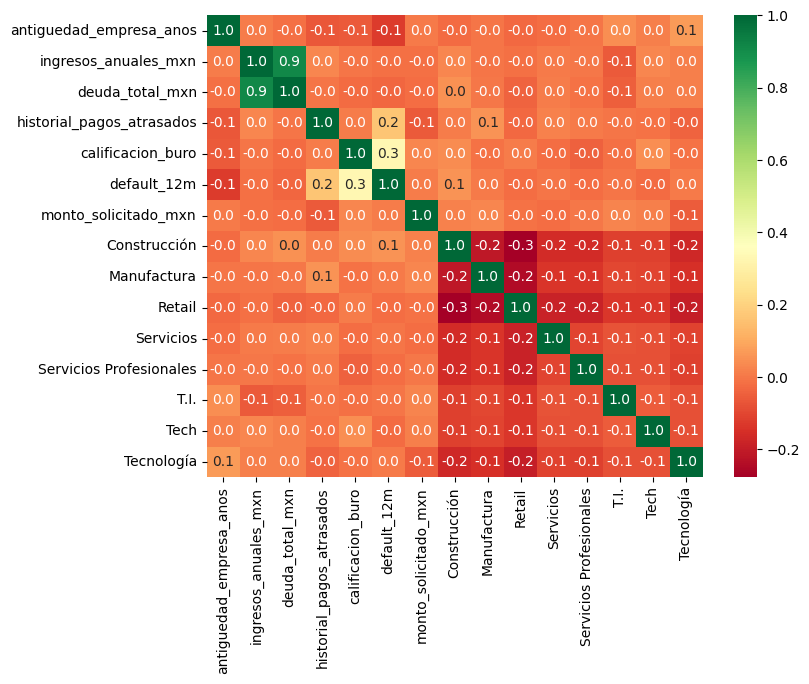

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))  
sns.heatmap(
    credit_data_platinum.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

ok. Hay alguna variables muy correlacionadas entre sí. hasta el momento no hay una correción fuerte con nuestra variable objetivo `dfaul_12m`. Agreguemos algunas otra variables.

In [38]:
credit_data_platinum["ratio_solicitud_ingresos"] = credit_data_platinum["monto_solicitado_mxn"] / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["ratio_deuda_ingresos"] = credit_data_platinum["deuda_total_mxn"] / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["carga_total_ingresos"] = (credit_data_platinum["deuda_total_mxn"] + credit_data_platinum["monto_solicitado_mxn"]) / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["flag_ingresos_disponibles"] = credit_data_platinum["ingresos_anuales_mxn"].notna().astype(int)
credit_data_platinum["flag_antiguedad"] = credit_data_platinum["antiguedad_empresa_anos"].notna().astype(int)

credit_data_platinum.head()

,id_cliente,antiguedad_empresa_anos,sector_industrial,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,default_12m,monto_solicitado_mxn,Construcción,...,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología,ratio_solicitud_ingresos,ratio_deuda_ingresos,carga_total_ingresos,flag_ingresos_disponibles,flag_antiguedad
0,COV-1000,9.50,Manufactura,5388966.19,4093290.34,1,4,0,1042088.49,0,...,0,0,0,0,0,0.19,0.76,0.95,1,1
1,COV-1001,6.90,Construcción,806689.27,184032.16,3,3,0,658716.30,1,...,0,0,0,0,0,0.82,0.23,1.04,1,1
2,COV-1002,10.20,Servicios Profesionales,4721557.55,2875892.65,1,2,0,656435.67,0,...,0,1,0,0,0,0.14,0.61,0.75,1,1
3,COV-1003,15.80,Retail,400301.58,284881.54,1,2,0,289018.04,0,...,0,0,0,0,0,0.72,0.71,1.43,1,1
4,COV-1004,6.60,Retail,6110431.90,5935242.68,2,0,0,694186.35,0,...,0,0,0,0,0,0.11,0.97,1.08,1,1


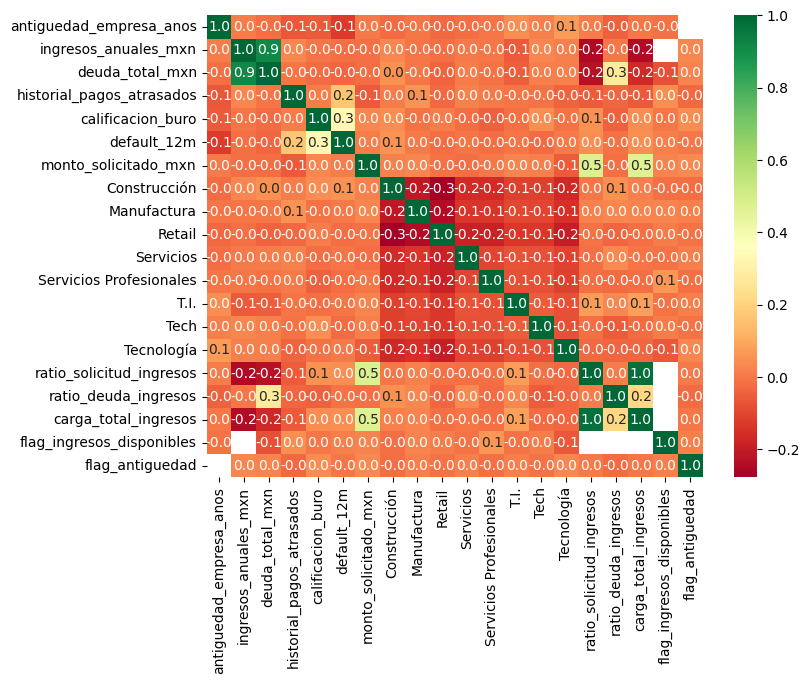

In [39]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    credit_data_platinum.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

# Escalado de datos

En el análisis exploratorio se identifico que las variables tienen escalas muy diferentes, así mismo, aun que se eliminaron los valores atípicos, las distribuciones de los datos estan sesgadas positivamente, es decir tiene una cola a la derecha de la distribución. Dado esto, se decidió escalar los datos utilizando RobustScaler.

El escalado de datos consiste en transformar las variables a una escala más reducida y manejable para los modelos de machine learning. RobustScaler es especialmente adecuado en presencia de valores atípicos o distribuciones con colas alargadas, ya que realiza la transformación utilizando la mediana y el rango intercuartílico (IQR). Matemáticamente, se define como:

$RobustScaler = \frac{X_i - \text{mediana}}{\text{IQR}}$

Dicho esto, crearemos la función `escalar_datos` la cual resive un dataframe y lo escala utilizando RobustScaler().

In [39]:
from sklearn import preprocessing
def escalar_datos(no_escalar,df):
    X = df.drop(columns=no_escalar,axis=1)
    y = df[no_escalar]
    escalador = preprocessing.RobustScaler()
    X_nor = pd.DataFrame(escalador.fit_transform(X),
                         columns = X.columns,
                         index=X.index)
    dfnor = pd.concat([y,X_nor],axis=1)
    return dfnor,escalador

Dato que no todas las variables necesitan ser escaladas, seleccionemos aquellas características en la que sus datos están en el rango de 0 a 1.

In [40]:
# definimos las columnas que no se van a escalar
no_escalar = [col for col in credit_data_platinum.columns if credit_data_platinum[col].max()==1 and credit_data_platinum[col].min()==0]
print(no_escalar)

['default_12m', 'Construcción', 'Manufactura', 'Retail', 'Servicios', 'Servicios Profesionales', 'T.I.', 'Tech', 'Tecnología', 'flag_ingresos_disponibles', 'flag_antiguedad']


Ahora si, escalemos los datos.

In [41]:
df = credit_data_platinum.select_dtypes(include=['number'])
df_esc,esc_df = escalar_datos(no_escalar,
                          df = df)
df_esc.head()


,default_12m,Construcción,Manufactura,Retail,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología,flag_ingresos_disponibles,flag_antiguedad,antiguedad_empresa_anos,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,monto_solicitado_mxn,ratio_solicitud_ingresos,ratio_deuda_ingresos,carga_total_ingresos
0,0,0,1,0,0,0,0,0,0,1,1,0.38,0.54,0.87,0.00,1.00,0.92,0.20,0.61,0.39
1,0,1,0,0,0,0,0,0,0,1,1,-0.14,-0.53,-0.57,2.00,0.50,0.35,2.24,-1.37,0.60
2,0,0,0,0,0,1,0,0,0,1,1,0.52,0.38,0.42,0.00,0.00,0.35,0.02,0.05,-0.08
3,0,0,0,1,0,0,0,0,0,1,1,1.64,-0.62,-0.53,0.00,0.00,-0.20,1.93,0.43,1.49
4,0,0,0,1,0,0,0,0,0,1,1,-0.20,0.70,1.54,1.00,-1.00,0.40,-0.07,1.40,0.69


Con estos datos escalados, veamos como se comportan los modelos en su estado por defecto. 

In [42]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Variables dependientes e independientes
independientes = df_esc.drop(columns=['default_12m'], axis=1) 
objetivo = df_esc['default_12m']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

# Calcular el ratio para XGBoost (positivos = 1, negativos = 0)
neg, pos = np.bincount(Y_train)
ratio = neg / pos

# Definir modelos con pesos para clases desbalanceadas
models = [
    lambda: HistGradientBoostingClassifier(class_weight="balanced", random_state=42),
    lambda: DecisionTreeClassifier(class_weight="balanced", random_state=42),
    lambda: RandomForestClassifier(class_weight="balanced", random_state=42),
    lambda: XGBClassifier(
        scale_pos_weight=ratio,
        random_state=42,
        eval_metric="logloss"
    ),
    lambda: BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
        random_state=42
    )
]

def model(Y_test, Y_train, X_test, X_train, model_instance):
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    y_pred_proba = model_instance.predict_proba(X_test)[:, 1]

    # Métricas generales
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    # MÉTRICAS ESPECÍFICAS CLASE MINORITARIA (DEFAULT=1)
    prec_minority = precision_score(Y_test, y_pred, pos_label=1, zero_division=0)
    rec_minority = recall_score(Y_test, y_pred, pos_label=1, zero_division=0)
    f1_minority = f1_score(Y_test, y_pred, pos_label=1, zero_division=0)
    
    # MÉTRICAS DE PROBABILIDAD 
    roc_auc = roc_auc_score(Y_test, y_pred_proba)
    avg_precision = average_precision_score(Y_test, y_pred_proba)

    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
        'Recall_Minority': round(rec_minority, 4),
        'Precision_Minority': round(prec_minority, 4),
        'F1_Minority': round(f1_minority, 4),
        'ROC_AUC': round(roc_auc, 4),
        'Avg_Precision': round(avg_precision, 4)
    }
    
    return model_instance, results

# Entrenar y evaluar
trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class())
    trained_models.append(model_instance)
    results_list.append(results)

# DataFrame de resultados
results_df = pd.DataFrame(results_list)

# Ordenar por Accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df.head()

,Model,Accuracy,Precision,Recall,F1-Score,Recall_Minority,Precision_Minority,F1_Minority,ROC_AUC,Avg_Precision
2,RandomForestClassifier,0.88,0.84,0.88,0.84,0.06,0.50,0.10,0.82,0.41
0,HistGradientBoostingClassifier,0.86,0.85,0.86,0.86,0.34,0.39,0.36,0.80,0.42
3,XGBClassifier,0.86,0.85,0.86,0.85,0.29,0.37,0.32,0.82,0.42
4,BaggingClassifier,0.85,0.81,0.85,0.83,0.09,0.20,0.12,0.82,0.30
1,DecisionTreeClassifier,0.83,0.82,0.83,0.82,0.23,0.24,0.24,0.57,0.15


Podemos observar que los modelos muestran un buen ajuste a los datos; sin embargo, existe un problema importante: **las clases están fuertemente desbalanceadas**. Esto provoca que los modelos tiendan a sesgarse hacia la clase mayoritaria, que en este caso corresponde a la clase 0 (clientes que no han incumplido).

Si recordamos, el objetivo es “desarrollar un modelo predictivo que estime la probabilidad de que un nuevo solicitante de crédito PYME incurra en incumplimiento dentro de los siguientes 12 meses”. Bajo este escenario, estos modelos probrados hasta ahora son efectivos para identificar a quienes no incumplen, pero pueden presentar dificultades al predecir a los clientes que sí lo hacen.

Por lo tanto, es necesario abordar este inconveniente. Una de las estrategias más adecuadas en este punto es aplicar técnicas de balanceo de clases para mejorar la capacidad predictiva del modelo frente a la clase minoritaria.

# Balanceo de clases

Dado que la clase mayoritaria corresponde a la clase 0, con un 88.20% del total de los registros, una técnica adecuada para balancear las clases es aplicar submuestreo sobre esta categoría. El objetivo principal es obtener una submuestra representativa de la clase 0 que contenga una cantidad de observaciones equivalente a la disponible en la clase 1.

Desde el punto de vista estadístico, esta decisión se fundamenta en la necesidad de reducir el sesgo en la estimación del modelo. Cuando existe un desbalance extremo, como en este caso, los algoritmos de clasificación tienden a favorecer a la clase mayoritaria. Esto puede llevar a un modelo con alta exactitud aparente, pero con bajo poder discriminatorio frente a la clase minoritaria.

El submuestreo permite aproximar la distribución de clases a una situación de equiprobabilidad. En otras palabras, la reducción del tamaño de la clase 0 equilibra las probabilidades de clasificación, evitando que el modelo se entrene con una fuerte inclinación hacia la clase mayoritaria.

In [43]:
df_esc['default_12m'].value_counts()

default_12m
0    1316
1     176
Name: count, dtype: int64

## Balanceo estratificado

In [44]:
class0 = credit_data_platinum[credit_data_platinum['default_12m']==0]
class1 = credit_data_platinum[credit_data_platinum['default_12m']==1]

clase_0_sub, _ = train_test_split(
    class0 ,
    train_size=176, 
    stratify=class0 ['sector_industrial'],  # estratificación
    random_state=43,
    shuffle=True
)
clase_0_sub.shape

(176, 22)

In [45]:
df_submuestreado_estr = pd.concat([clase_0_sub,class1],axis=0)
#df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)
df_submuestreado_estr['default_12m'].value_counts()

default_12m
0    176
1    176
Name: count, dtype: int64

In [46]:
df_submuestreado_estr.head()

,id_cliente,antiguedad_empresa_anos,sector_industrial,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,default_12m,monto_solicitado_mxn,Construcción,...,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología,ratio_solicitud_ingresos,ratio_deuda_ingresos,carga_total_ingresos,flag_ingresos_disponibles,flag_antiguedad
678,COV-1678,11.80,Manufactura,675361.59,294177.24,1,1,0,63458.49,0,...,0,0,0,0,0,0.09,0.44,0.53,1,1
492,COV-1492,7.70,Manufactura,1261338.00,902452.91,4,1,0,138404.27,0,...,0,0,0,0,0,0.11,0.72,0.83,1,1
93,COV-1093,6.30,Tecnología,553354.25,155174.68,2,2,0,507243.60,0,...,0,0,0,0,1,0.92,0.28,1.20,1,1
610,COV-1610,10.20,Retail,694563.92,299263.55,1,2,0,300175.99,0,...,0,0,0,0,0,0.43,0.43,0.86,1,1
683,COV-1683,9.40,Manufactura,817504.80,488893.24,2,1,0,993773.61,0,...,0,0,0,0,0,1.22,0.60,1.81,1,1


Perfecto!. En este caso se utilizó un muestreo estratificado por sector industrial. Esto asegura que la proporción de clientes por sector sector empresarial en la submuestra se mantenga similar a la distribución original de la clase 0, evitando la pérdida de diversidad sectorial y reduciendo posibles sesgos en el entrenamiento del modelo

Ahora, veamos como se comportan los modelos en su estado por defecto.

In [47]:
no_escalar = [col for col in df_submuestreado_estr.columns if df_submuestreado_estr[col].max()==1 and df_submuestreado_estr[col].min()==0]
df_submuestreado_estr = df_submuestreado_estr.select_dtypes(include=['number'])

df_submuestreado_estr_esc,esc_df_submuestreado_estr_ = escalar_datos(no_escalar,
                                                                     df = df_submuestreado_estr)
df_submuestreado_estr_esc.head()

,default_12m,Construcción,Manufactura,Retail,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología,flag_ingresos_disponibles,flag_antiguedad,antiguedad_empresa_anos,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,monto_solicitado_mxn,ratio_solicitud_ingresos,ratio_deuda_ingresos,carga_total_ingresos
678,0,0,1,0,0,0,0,0,0,1,1,0.92,-0.48,-0.50,-0.50,-1.00,-0.50,-0.14,-0.53,-0.55
492,0,0,1,0,0,0,0,0,0,1,1,0.10,-0.34,-0.25,1.00,-1.00,-0.40,-0.09,0.46,0.04
93,0,0,0,0,0,0,0,0,1,1,1,-0.18,-0.51,-0.56,0.00,-0.50,0.10,2.36,-1.08,0.78
610,0,0,0,1,0,0,0,0,0,1,1,0.60,-0.48,-0.50,-0.50,-0.50,-0.18,0.89,-0.55,0.11
683,0,0,1,0,0,0,0,0,0,1,1,0.44,-0.45,-0.42,0.00,-1.00,0.76,3.27,0.04,2.01


In [ ]:
# Variables dependientes e independientes
independientes_sub_str = df_submuestreado_estr_esc.drop(columns=['default_12m'], axis=1) 
objetivo_sub_str = df_submuestreado_estr_esc['default_12m']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes_sub_str,
    objetivo_sub_str,
    test_size=0.05,
    random_state=42,
    shuffle=True,
    stratify=objetivo_sub_str
)

def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    
    # Métricas generales
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Crear diccionario con resultados
    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    # Devolver tanto el modelo como los resultados
    return model_instance, results

# Ejecutar modelos y recolectar resultados
models = [
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    XGBClassifier,
    BaggingClassifier,
    DecisionTreeClassifier
]
trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class)
    trained_models.append(model_instance)
    results_list.append(results)

# Convertir a DataFrame
results_df = pd.DataFrame(results_list)

# Ordenar por Accuracy (de mayor a menor)
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df.head(len(results_df))

,Model,Accuracy,Precision,Recall,F1-Score
0,HistGradientBoostingClassifier,0.61,0.62,0.56,0.59
1,RandomForestClassifier,0.61,0.62,0.56,0.59
2,XGBClassifier,0.61,0.62,0.56,0.59
4,DecisionTreeClassifier,0.61,0.62,0.56,0.59
3,BaggingClassifier,0.56,0.56,0.56,0.56


Podemos observar que el mayor f1-score es de 0.74, veamos ahora que pasa si submuestreamos la clase mayoritaria de forma aleatoria.

## Balanceo aleatorio

In [48]:
class0 = credit_data_platinum[credit_data_platinum['default_12m']==0]
class1 = credit_data_platinum[credit_data_platinum['default_12m']==1]
clase_0_sub_sample = class0.sample(n=176, random_state=43)

df_submuestreado_sample = pd.concat([clase_0_sub_sample,class1],axis=0)
df_submuestreado_sample['default_12m'].value_counts()

default_12m
0    176
1    176
Name: count, dtype: int64

In [49]:
no_escalar = [col for col in df_submuestreado_sample.columns if df_submuestreado_sample[col].max()==1 and df_submuestreado_sample[col].min()==0]
df_submuestreado_sample= df_submuestreado_sample.select_dtypes(include=['number'])
df_submuestreado_sample_esc,esc_df_submuestreado_sample = escalar_datos(no_escalar,
                                                                        df = df_submuestreado_sample)
df_submuestreado_sample_esc.head()

,default_12m,Construcción,Manufactura,Retail,Servicios,Servicios Profesionales,T.I.,Tech,Tecnología,flag_ingresos_disponibles,flag_antiguedad,antiguedad_empresa_anos,ingresos_anuales_mxn,deuda_total_mxn,historial_pagos_atrasados,calificacion_buro,monto_solicitado_mxn,ratio_solicitud_ingresos,ratio_deuda_ingresos,carga_total_ingresos
369,0,0,1,0,0,0,0,0,0,0,1,-0.36,NaN,-0.08,0.50,-0.80,0.33,NaN,NaN,NaN
765,0,1,0,0,0,0,0,0,0,1,1,-0.31,-0.63,-0.61,0.00,-0.80,-0.45,1.15,0.06,0.69
676,0,0,0,1,0,0,0,0,0,1,1,-0.53,1.14,1.35,1.00,-0.80,1.09,-0.04,0.15,-0.05
1397,0,0,0,1,0,0,0,0,0,1,1,-0.47,0.27,0.32,-0.50,-0.80,0.37,0.03,0.00,-0.10
1147,0,0,0,0,1,0,0,0,0,1,1,-0.67,-0.07,-0.11,0.00,0.00,1.20,0.99,-0.23,0.38


In [50]:
# Variables dependientes e independientes

independientes_sub_sample = df_submuestreado_sample_esc.drop(columns=['default_12m'], axis=1) 
objetivo_sub_sample = df_submuestreado_sample_esc['default_12m']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes_sub_sample ,
    objetivo_sub_sample ,
    test_size=0.05,
    random_state=42,
    shuffle=True,
    stratify=objetivo_sub_sample 
)

def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)
    
    # Métricas generales
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    rec = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Crear diccionario con resultados
    results = {
        'Model': type(model_instance).__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    }
    
    # Devolver tanto el modelo como los resultados
    return model_instance, results

# Ejecutar modelos y recolectar resultados
models = [
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    XGBClassifier,
    BaggingClassifier,
    DecisionTreeClassifier
]
trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class)
    trained_models.append(model_instance)
    results_list.append(results)

# Convertir a DataFrame
results_df = pd.DataFrame(results_list)

# Ordenar por Acuracy (de mayor a menor)
results_df = results_df.sort_values('Accuracy', ascending=False)
results_df.head(len(results_df))

,Model,Accuracy,Precision,Recall,F1-Score
1,RandomForestClassifier,0.78,0.86,0.67,0.75
3,BaggingClassifier,0.78,0.86,0.67,0.75
0,HistGradientBoostingClassifier,0.72,0.83,0.56,0.67
4,DecisionTreeClassifier,0.72,0.75,0.67,0.71
2,XGBClassifier,0.67,0.67,0.67,0.67


Ok… hay una ligera mejora.

Con base en esto, entrenaremos algunos de estos modelos utilizando tanto el dataset con clases desbalanceadas como el dataset con clases balanceadas, y evaluaremos su desempeño en cada caso.

# Modelado

Ya conocemos nuestros datos y entendemos que, si entrenamos un modelo con un conjunto de datos altamente desbalanceado, este tenderá a sesgarse hacia la clase mayoritaria.
En nuestro caso, al aplicar un balanceo estratificado de las clases, observamos que los resultados mejoran de manera significativa.

Ahora bien, surge la pregunta: ¿qué métrica debemos utilizar para evaluar el desempeño del modelo?

Para responderla, revisemos primero las definiciones matemáticas de las principales métricas de evaluación:

 1. Precisión (Precision): Indica la habilidad del modelo para clasificar como postivo los casos que son positivos.

$\text{Precision} = \frac{TP}{TP + FP}$


- **TP (True Positives):** positivos correctamente predichos.  
- **FP (False Positives):** negativos predichos como positivos.


2. Recall (Sensibilidad): Nos da una medida de la habilidad del modelo para encontrar todos los casos positivos. Esta se mide en función de una clase.

$\text{Recall} = \frac{TP}{TP + FN}$


- **TP (True Positives):** positivos correctamente predichos.  
- **FN (False Negatives):** positivos no detectados por el modelo.


 3. Exactitud (Accuracy): Es la medida general de como se comporta el modelo, mide simplemente el porcentaje de casos que se han clasificado correctamente. No es un buen criterio para decir que el modelo es bueno.

$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$


- **TN (True Negatives):** negativos correctamente predichos.  
- **FP (False Positives):** negativos predichos como positivos.  
- **FN (False Negatives):** positivos no detectados.  


4. F1-Score: Combina precisión y recall en un solo número, es una muy buena métrica.

$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$


- Combina precisión y recall en un solo valor, útil para problemas con clases desbalanceadas.


**Clases balanceadas:** Se puede usar:

- **accuracy (Exactitud)** Mide los casos que se han clasificado correctamente. Ideal cuando todas las clases son de igual importancia.
- **f1_micro:** Útil cuando interesa el rendimiento general del modelo.
- **roc_auc_ovr:** Útil para evaluar el rendimiento de clasificadores binarios y multiclase.


**Clases desbalanceadas:** Se puede usar:

- **f1_weighted:** Refleja mejor rendimiento en un conjunto de datos desbalanceados.
- **f1_macro:** Proporciona una evaluación más equitativa del rendimiento del modelo en todas la clases.
- **precision_weighted:** Útil si se quiere minimazar los falsos positivos ajustados por el tamaño de clase.
- **recall_weighted:** Útil si se requiere minimizar los falsos negativos ajustados por el tamaño de clase.

Voy a elegir tres modelos a los cuáles les voy a encontrar los mejores hiperparámetros, con el objetivo de evitar el overfitting o el underfitting. Los modelos elegidos son los siguientes:

- `RandomForestClassifier`: Ya que es robusto ante valores atípicos,permite datos faltantes y captura relaciones complejas.
- `XGBClassifier`: 
- `DecisionTreeClassifier`: Saco buen F1_score en el dataset submeuestreado

## Hyperparameter Optimization

La optimización de hiperparámetros se llevará a cabo utilizando Optuna, una herramienta diseñada para maximizar o minimizar funciones objetivo. En nuestro caso, la función objetivo será el F1-Score, que buscamos maximizar. Para ello, aplicaremos validación cruzada con el fin de obtener los hiperparámetros que aseguren que los modelos no presenten sobreajuste ni subajuste.

A continuación, definimos la función **evaluar_modelo**; esta se encargará de evaluar los modelos utilizando validación cruzada.


In [51]:
from sklearn.model_selection import cross_validate
def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes, objetivo,
                     scoring="f1", n_jobs=-1, cv=30)
    return resultados_estimador

### XGBoost Dataset completo

In [52]:
import optuna
from xgboost import XGBClassifier
from collections import Counter
def optimizar_xgb(trial):
    counter = Counter(objetivo)
    scale_pos_weight = counter[0] / counter[1]
    param_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 120),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0, step=0.1),
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight
    }
    xgb = XGBClassifier(**param_xgb)
    resultados_xgb = cross_validate(xgb,independientes , objetivo, scoring="f1_macro", n_jobs=-1, cv=60)
    return np.mean(resultados_xgb["test_score"])

In [53]:
independientes = df_esc.drop(columns=['default_12m'], axis=1) 
objetivo = df_esc['default_12m']  
estudioGBClassifier= optuna.create_study(direction="maximize")
n_trials = 100  
estudioGBClassifier.optimize(optimizar_xgb, n_trials=n_trials)

[I 2025-09-28 15:20:32,040] A new study created in memory with name: no-name-c84d40c5-382e-4936-b774-6832ff470ed3
[I 2025-09-28 15:20:35,852] Trial 0 finished with value: 0.6208011481309091 and parameters: {'n_estimators': 30, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.8, 'colsample_bytree': 0.2, 'gamma': 0.7000000000000001}. Best is trial 0 with value: 0.6208011481309091.
[I 2025-09-28 15:20:36,266] Trial 1 finished with value: 0.6461133957643667 and parameters: {'n_estimators': 21, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 15, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 0.2}. Best is trial 1 with value: 0.6461133957643667.
[I 2025-09-28 15:20:36,530] Trial 2 finished with value: 0.5848221821621646 and parameters: {'n_estimators': 12, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 14, 'subsample': 0.8, 'colsample_bytree': 0.2, 'gamma': 0.30000000000000004}. Best is trial 1 with value: 0.6461133957643667.
[I 2025-0

In [54]:
print(estudioGBClassifier.best_params)
print(estudioGBClassifier.best_value)

{'n_estimators': 105, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.1, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.4}
0.6938351573643133


Interpretación de F1 macro ~ 0.69

- Indica que, en promedio, que el modelo acierta bastante bien entre precision y recall para todas las clases.

- No es perfecto, pero es razonablemente bueno teniendo en cuenta que este es el dataset completo en donde las clases están muy desbalanceadas. Veamos ahora cuanto obtenemos con el dataset submuestreado.

### XGBoost Dataset submuestreado

In [55]:
independientes_sub_str = df_submuestreado_estr_esc.drop(columns=['default_12m'], axis=1)
objetivo_sub_str =  df_submuestreado_estr_esc['default_12m']


def optimizar_xgb(trial):
    counter = Counter(objetivo)
    scale_pos_weight = counter[0] / counter[1]
    param_xgb = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 120),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0, step=0.1),
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight
    }
    xgb = XGBClassifier(**param_xgb)
    resultados_xgb = cross_validate(xgb,independientes_sub_str , objetivo_sub_str, scoring="f1", n_jobs=-1, cv=10)
    return np.mean(resultados_xgb["test_score"])

estudioGBClassifier_sub= optuna.create_study(direction="maximize")
n_trials = 200  
estudioGBClassifier_sub.optimize(optimizar_xgb, n_trials=n_trials)

[I 2025-09-28 15:22:06,677] A new study created in memory with name: no-name-92253979-508e-43b9-9f2f-9d166e387bfc
[I 2025-09-28 15:22:06,717] Trial 0 finished with value: 0.666569908079342 and parameters: {'n_estimators': 11, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 14, 'subsample': 0.1, 'colsample_bytree': 0.8, 'gamma': 0.9}. Best is trial 0 with value: 0.666569908079342.
[I 2025-09-28 15:22:06,785] Trial 1 finished with value: 0.666569908079342 and parameters: {'n_estimators': 46, 'learning_rate': 0.01, 'max_depth': 16, 'min_child_weight': 12, 'subsample': 0.8, 'colsample_bytree': 0.5, 'gamma': 1.0}. Best is trial 0 with value: 0.666569908079342.
[I 2025-09-28 15:22:06,825] Trial 2 finished with value: 0.666569908079342 and parameters: {'n_estimators': 20, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 13, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.5}. Best is trial 0 with value: 0.666569908079342.
[I 2025-09-28 15:22:06,893] T

In [56]:
print(estudioGBClassifier_sub.best_params)
print(estudioGBClassifier_sub.best_value)

{'n_estimators': 105, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.7000000000000001}
0.766130049313618


Vemos que mejoró! 

### RandomForestClassifier Dataset completo

In [57]:
from sklearn.ensemble import RandomForestClassifier

def optimizar_Forestre_class(trial):
    # Definir espacio de búsqueda de hiperparámetros
    param_grid_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 120),  # Número de árboles
        'max_depth': trial.suggest_int('max_depth', 2, 16),  # Profundidad máxima de los árboles
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),  # Features por split
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),  # Mínimas muestras para dividir un nodo
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),  # Mínimas muestras en una hoja
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Si usar muestreo con reemplazo
        'class_weight': 'balanced'  # Ajustar pesos según el desequilibrio de clases
    }

    # Crear el modelo de clasificación
    Forestre = RandomForestClassifier(**param_grid_rf)

    # Validación cruzada usando f1_macro
    resultados_Forestre = cross_validate(
        Forestre,
        independientes,
        objetivo,
        scoring="f1_macro",
        n_jobs=-1,
        cv=60
    )

    # Retornar la media de la métrica
    return np.mean(resultados_Forestre["test_score"])


In [59]:
estudioRandomRandomForestClassifier= optuna.create_study(direction="maximize")
n_trials = 100  
estudioRandomRandomForestClassifier.optimize(optimizar_Forestre_class, n_trials=n_trials)

[I 2025-09-28 15:25:29,093] A new study created in memory with name: no-name-f8c6a71c-dce8-4663-bd38-4f9eeffce46e
[I 2025-09-28 15:25:29,534] Trial 0 finished with value: 0.639593657502184 and parameters: {'n_estimators': 13, 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 0.639593657502184.
[I 2025-09-28 15:25:36,073] Trial 1 finished with value: 0.6420448040816102 and parameters: {'n_estimators': 83, 'max_depth': 12, 'max_features': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.6420448040816102.
[I 2025-09-28 15:25:37,580] Trial 2 finished with value: 0.6201076628303249 and parameters: {'n_estimators': 21, 'max_depth': 16, 'max_features': 0.8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 1 with value: 0.6420448040816102.
[I 2025-09-28 15:25:47,607] Trial 3 finished with value: 0.6454456068216509 and paramet

In [60]:
print(estudioRandomRandomForestClassifier.best_params)
print(estudioRandomRandomForestClassifier.best_value)

{'n_estimators': 51, 'max_depth': 9, 'max_features': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True}
0.6896983230948857


## RandomForestClassifier Dataset submuestreado

In [61]:
from sklearn.ensemble import RandomForestClassifier

def optimizar_Forestre_class(trial):
    # Definir espacio de búsqueda de hiperparámetros
    param_grid_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 120),  # Número de árboles
        'max_depth': trial.suggest_int('max_depth', 2, 16),  # Profundidad máxima de los árboles
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),  # Features por split
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),  # Mínimas muestras para dividir un nodo
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),  # Mínimas muestras en una hoja
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),  # Si usar muestreo con reemplazo
        'class_weight': 'balanced'  # Ajustar pesos según el desequilibrio de clases
    }

    # Crear el modelo de clasificación
    Forestre = RandomForestClassifier(**param_grid_rf)

    # Validación cruzada usando f1_macro
    resultados_Forestre = cross_validate(
        Forestre,
        independientes_sub_str, 
        objetivo_sub_str,
        scoring="f1",
        n_jobs=-1,
        cv=10
    )

    # Retornar la media de la métrica
    return np.mean(resultados_Forestre["test_score"])

estudio_RandomForestClassifier_sub= optuna.create_study(direction="maximize")
n_trials = 200  
estudio_RandomForestClassifier_sub.optimize(optimizar_Forestre_class, n_trials=n_trials)

[I 2025-09-28 15:31:16,102] A new study created in memory with name: no-name-7d96e2cf-1063-44e6-84d9-799c2478859e
[I 2025-09-28 15:31:16,279] Trial 0 finished with value: 0.7194271678906654 and parameters: {'n_estimators': 30, 'max_depth': 6, 'max_features': 1.0, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.7194271678906654.
[I 2025-09-28 15:31:16,476] Trial 1 finished with value: 0.7483257230316054 and parameters: {'n_estimators': 81, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.7483257230316054.
[I 2025-09-28 15:31:16,653] Trial 2 finished with value: 0.7563752385733811 and parameters: {'n_estimators': 84, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 2 with value: 0.7563752385733811.
[I 2025-09-28 15:31:16,778] Trial 3 finished with value: 0.7156730060445231 and pa

In [62]:
print(estudio_RandomForestClassifier_sub.best_params)
print(estudio_RandomForestClassifier_sub.best_value)

{'n_estimators': 104, 'max_depth': 4, 'max_features': 1.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}
0.7721254738901797


### DecisionTreeClassifier Dataset completo

In [63]:
def optimizar_tree(trial):
    # Definir espacio de búsqueda de hiperparámetros
    param_grid_tree = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Crear modelo
    tree = DecisionTreeClassifier(**param_grid_tree, random_state=42)

    # Validación cruzada con f1_macro
    resultados_tree = cross_validate(
        tree,
        independientes,
        objetivo,
        scoring="f1_macro",
        n_jobs=-1,
        cv=60
    )

    # Retornar la media de la métrica
    return np.mean(resultados_tree["test_score"])


# Optimización con Optuna
estudio_TreeClassifier = optuna.create_study(direction="maximize")
n_trials = 100 
estudio_TreeClassifier.optimize(optimizar_tree, n_trials=n_trials)

[I 2025-09-28 15:32:23,002] A new study created in memory with name: no-name-df52891b-5ec4-4662-bda1-96b1f3d58041
[I 2025-09-28 15:32:23,169] Trial 0 finished with value: 0.5988942091053496 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5988942091053496.
[I 2025-09-28 15:32:23,278] Trial 1 finished with value: 0.5212770084912662 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5988942091053496.
[I 2025-09-28 15:32:23,407] Trial 2 finished with value: 0.5748490457480349 and parameters: {'criterion': 'log_loss', 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.5988942091053496.
[I 2025-09-28 15:32:23,519] Trial 3 finished wit

In [64]:
print(estudio_TreeClassifier.best_params)
print(estudio_TreeClassifier.best_value)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None, 'class_weight': 'balanced'}
0.6509024910773795


### DecisionTreeClassifier Dataset submuestreado

In [65]:

def optimizar_tree(trial):
    # Definir espacio de búsqueda de hiperparámetros
    param_grid_tree = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Crear modelo
    tree = DecisionTreeClassifier(**param_grid_tree, random_state=42)

    # Validación cruzada con f1_macro
    resultados_tree = cross_validate(
        tree,
        independientes_sub_str,
        objetivo_sub_str,
        scoring="f1",
        n_jobs=-1,
        cv=10
    )

    # Retornar la media de la métrica
    return np.mean(resultados_tree["test_score"])


# Optimización con Optuna
estudio_TreeClassifier_sub = optuna.create_study(direction="maximize")
n_trials = 200 
estudio_TreeClassifier_sub.optimize(optimizar_tree, n_trials=n_trials)


[I 2025-09-28 15:32:45,594] A new study created in memory with name: no-name-e9b25980-e93b-430d-bebc-4e8d2b6767d7
[I 2025-09-28 15:32:45,620] Trial 0 finished with value: 0.673736524650087 and parameters: {'criterion': 'gini', 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.673736524650087.
[I 2025-09-28 15:32:45,645] Trial 1 finished with value: 0.6469631259357908 and parameters: {'criterion': 'log_loss', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.673736524650087.
[I 2025-09-28 15:32:45,670] Trial 2 finished with value: 0.6115300269208938 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.673736524650087.
[I 2025-09-28 15:32:45,695] Trial 3 finished with value: 0.626

In [66]:
print(estudio_TreeClassifier_sub.best_params)
print(estudio_TreeClassifier_sub.best_value)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 15, 'max_features': None, 'class_weight': None}
0.7601635864484162


Como podemos observar, hasta el momento el f1-score más alto es de muy cercano a 0.78. 

## Compentencia entre modelos en clases balanceadas

Con los parámetros óptimos encontrados para cada modelo, evaluaremos su desempeño.

In [67]:
def ver_resultados(resultados):
    resultados_df = pd.DataFrame(resultados).T
    # Iterar sobre cada columna del DataFrame
    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)
        resultados_df[col + "_idx"] = resultados_df[col] / resultados_df[col].max()
    return resultados_df

Obtenemos los resultados de los modelos con sus parámetros óptimos encontrados para el dataset con clases balanceadas, utilizando 10 particiones en validación cruzada para obtener estimaciones más estables y confiables del rendimiento de cada uno de estos modelos.

In [68]:
xgb = XGBClassifier(**estudioGBClassifier_sub.best_params)
forest = RandomForestClassifier(**estudio_RandomForestClassifier_sub.best_params)
dtree = DecisionTreeClassifier(**estudio_TreeClassifier_sub.best_params)
resultados = {}

def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes_sub_str, objetivo_sub_str,
                                          scoring="f1", n_jobs=-1, cv=10)
    return resultados_estimador

resultados["XGBClassifier"] = evaluar_modelo(xgb,
                                   independientes_sub_str,
                                   objetivo_sub_str)
resultados["RandomForestClassifier"] = evaluar_modelo(forest,
                                   independientes_sub_str,
                                   objetivo_sub_str)
resultados["DecisionTreeClassifier"] = evaluar_modelo(dtree,
                                   independientes_sub_str,
                                   objetivo_sub_str)

In [69]:
resultados_df= ver_resultados(resultados)
resultados_df = resultados_df.sort_values(by=['test_score', 'fit_time'], ascending=[False, True])
resultados_df.head()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
XGBClassifier,0.13,0.01,0.76,0.40,0.53,1.00
DecisionTreeClassifier,0.00,0.00,0.76,0.01,0.30,1.00
RandomForestClassifier,0.33,0.01,0.76,1.00,1.00,0.99


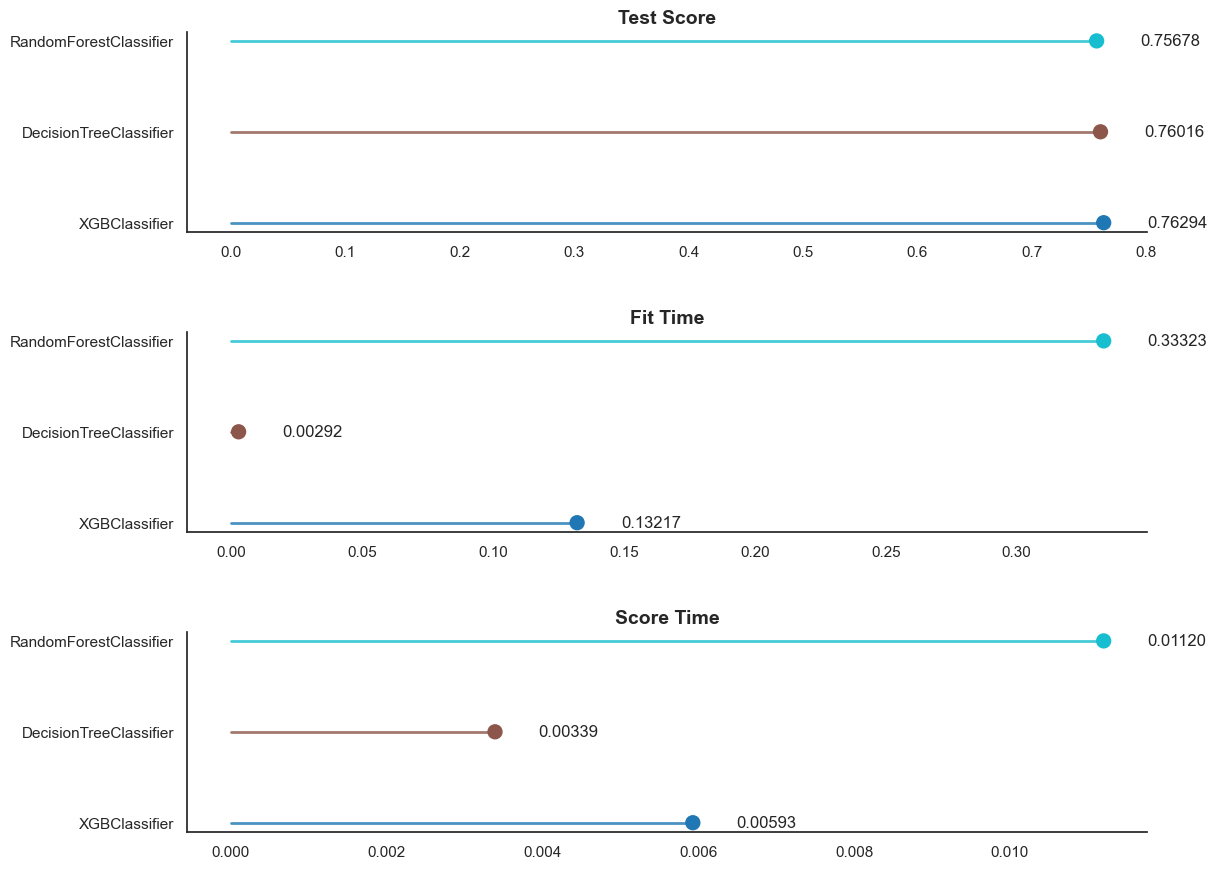

In [70]:
fig = plt.figure(figsize=(12, 10))

sns.set_theme(style="white")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "axes.titleweight": "bold"
})

# Métricas a graficar
metrics = ["test_score", "fit_time", "score_time"]
titles = ["Test Score", "Fit Time", "Score Time"]


for i, (metric, title) in enumerate(zip(metrics, titles)):
    # Crear subplot dinámico
    ax = fig.add_axes([0.1, 0.7 - i * 0.3, 0.8, 0.2]) 

    # Extraer datos
    x = resultados_df.index  
    y = resultados_df[metric]

    # Generar colores automáticamente
    colores = plt.cm.tab10(np.linspace(0, 1, len(x)))

    # Dibujar las líneas verticales
    for xi, yi, color in zip(x, y, colores):
        ax.plot([0, yi], [xi, xi], color=color, lw=2, alpha=0.8)

    # Dibujar los puntos
    ax.scatter(y, x, color=colores, s=100, zorder=2)

    # Añadir los valores como texto
    max_y = max(abs(y)) 
    for yi, xi in zip(y, x):
        texto_x = yi + (max_y * 0.05 if yi >= 0 else -max_y * 0.05)
        ax.text(texto_x, xi, f'{yi:.5f}', va='center', ha='left')

    # Configuración del subplot
    ax.set_title(title, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

Podemos observar que hasta el momento el mejor modelo es DesicionTreeClassifier.

## Compentencia entre modelos en clases desbalanceadas

In [71]:
xgb_des = XGBClassifier(**estudioGBClassifier.best_params)
forest_des = RandomForestClassifier(**estudioRandomRandomForestClassifier.best_params)
dtree_des = DecisionTreeClassifier(**estudio_TreeClassifier.best_params)
resultados_des = {}

def evaluar_modelo(estimador, independientes, objetivo):
    resultados_estimador = cross_validate(estimador, independientes, objetivo,
                                          scoring="f1_macro", n_jobs=-1, cv=60)
    return resultados_estimador

resultados_des["XGBClassifier"] = evaluar_modelo(xgb,
                                   independientes,
                                   objetivo)
resultados_des["RandomForestClassifier"] = evaluar_modelo(forest,
                                   independientes,
                                   objetivo)
resultados_des["DecisionTreeClassifier"] = evaluar_modelo(dtree,
                                   independientes,
                                   objetivo)

In [72]:
resultados_des_df= ver_resultados(resultados_des)
resultados_des_df = resultados_des_df.sort_values(by=['test_score', 'fit_time'], ascending=[False, True])
resultados_des_df.head()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
XGBClassifier,0.34,0.01,0.60,0.35,0.79,1.00
RandomForestClassifier,0.97,0.01,0.58,1.00,1.00,0.96
DecisionTreeClassifier,0.01,0.00,0.48,0.01,0.35,0.79


Podemos observar que el mayor f1-score es de 0.6, realmente le cuesta predecir la clase desbalanceada.

## Feature importance

Ya hemos identificado el mejor modelo para ambos datasets, pero, ¿cuáles son las características que este considera más importantes?

Para dar respuesta a esta pregunta, vamos a entrenar el modelo con los mejores parámetros encontrados (dataset con clases balanceadas) en la validación cruzada y veamos la importancia de características.

In [73]:
from sklearn.feature_selection import RFE

independientes_sub_str = df_submuestreado_estr_esc.drop(columns=['default_12m'], axis=1) 
objetivo_sub_str = df_submuestreado_estr_esc['default_12m']  

X_train, X_test, Y_train, Y_test = train_test_split(
    independientes_sub_str,
    objetivo_sub_str,
    test_size=0.1,
    random_state=42,
    shuffle=True,
    stratify=objetivo_sub_str
)

parameters ={'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': None, 'class_weight': None}
mejorModelo =DecisionTreeClassifier(**parameters)
mejorModelo.fit(X_train, Y_train)


rfe = RFE(mejorModelo, n_features_to_select=5)  # Seleccionar las 5 características más importantes
rfe = rfe.fit(X_train, Y_train)

# Mostrar las características seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['historial_pagos_atrasados', 'calificacion_buro',
       'monto_solicitado_mxn', 'ratio_deuda_ingresos', 'carga_total_ingresos'],
      dtype='object')


Habiendo identificado que las características más relevantes para las predicciones en el dataset balanceado son:

- historial_pagos_atrasados
- calificacion_buro
- monto_solicitado_mxn
- ratio_deuda_ingresos
- carga_total_ingresos

Y contando con los parámetros óptimos que minimizan los riesgos de sobreajuste y subajuste, procedemos a entrenar el modelo final utilizando exclusivamente estas variables seleccionadas.

# Evaluacion

## Modelos en datos con clases balanceadas

In [74]:
# Filtrar las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model_selected = DecisionTreeClassifier(**parameters)
model_selected.fit(X_train_selected, Y_train)

y_pred_reduced2 = model_selected.predict(X_test_selected )

# CÁLCULO DE MÉTRICAS INDIVIDUALES
f1 = f1_score(Y_test, y_pred_reduced2, pos_label=1)  # pos_label=1 para "no paga"
precision = precision_score(Y_test, y_pred_reduced2, pos_label=1)
recall = recall_score(Y_test, y_pred_reduced2, pos_label=1)

print("=== MÉTRICAS DEL MODELO ===")
print(f"F1-Score: {f1:.4f}")
print(f"Precisión: {precision:.4f}") 
print(f"Recall: {recall:.4f}")

=== MÉTRICAS DEL MODELO ===
F1-Score: 0.8571
Precisión: 0.8824
Recall: 0.8333


Podemos interpretar lo siguiente:

- `Precisión = 0.8824 (88%)`: De todos los clientes que el modelo marcó como incumplidores, casi 9 de cada 10 en verdad lo eran (pocos falsos positivos) 

- `Recall = 0.8333 (83%)`: De todos los clientes que realmente incumplieron, el modelo detectó 8 de cada 10 (Algunos falsos negativos, pero no demasiados).

- `F1-score = 0.8571 (86%):` Muestra que el modelo tiene un buen equilibrio entre no dejar escapar muchos incumplidores y no castigar injustamente a clientes buenos.

Veamos la matriz de confusión.

In [75]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

cm = confusion_matrix(Y_test, y_pred_reduced2, labels=[1, 0])  # 1 = positivo, 0 = negativo
# Convención estándar sklearn: 0 primero, 1 después
VP, FN = cm[0][0], cm[0][1]
FP, VN = cm[1][0], cm[1][1]

# Texto con etiquetas + valores
annotations = [
    [f'VP = {VP}', f'FN = {FN}'],
    [f'FP = {FP}', f'VN = {VN}']
]
clases = np.unique(Y_test)
# Crear el heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=[f'Predicho: {c}' for c in clases],
    y=[f'Real: {c}' for c in clases],
    annotation_text=annotations,
    colorscale='Blues',
    showscale=True
)

fig.update_layout(
    title='Matriz de Confusión con Etiquetas y Valores',
    xaxis_title='Predicción del Modelo',
    yaxis_title='Estado Real',
    autosize=True
)

fig.show()



Podemos observar lo siguiente en el conjunto de prueba:

- Falsos Positivos (FP): 2 clientes fueron clasificados como incumplidores (1), pero en realidad no incumplieron (0).

- Verdaderos Positivos (VP): 15 clientes fueron clasificados como incumplidores (1) y efectivamente incumplieron (1).

- Verdaderos Negativos (VN): 16 clientes fueron clasificados como no incumplidores (0) y en realidad no incumplieron (0).

- Falsos Negativos (FN): 3 clientes fueron clasificados como no incumplidores (0), pero en realidad sí incumplieron (1).

Obtengamos las probabilidades de las predicciones.

In [76]:
print("Clases del modelo:", model_selected.classes_)
# Ver el orden específico
for i, clase in enumerate(model_selected.classes_):
    print(f"Columna {i}: Clase {clase}")

Clases del modelo: [0 1]
Columna 0: Clase 0
Columna 1: Clase 1


In [ ]:
y_proba_clas_bal = model_selected.predict_proba(X_test_selected)

proba_df_clas_bal = pd.DataFrame(y_proba_clas_bal, 
                       columns=['prob_clase_0', 'prob_clase_1'],
                       index=X_test_selected.index)
proba_df_clas_bal['Clase predicha'] = model_selected.predict(X_test_selected)
proba_df_clas_bal['Clase verdadera'] = Y_test
proba_df_clas_bal.head(8)

,prob_clase_0,prob_clase_1,Clase predicha,Clase verdadera
788,0.55,0.45,0,0
16,0.41,0.59,1,1
251,0.55,0.45,0,0
1378,0.83,0.17,0,1
519,0.15,0.85,1,1
1211,0.41,0.59,1,1
908,0.83,0.17,0,1
838,0.41,0.59,1,1


### Umbral de desicion

Actualmente nuestro modelo usa un umbral fijo de 0.5 para decidir si aprobar o rechazar un préstamo. Esto significa:

- Si probabilidad > 50% → `"No pagará"` → RECHAZAR

- Si probabilidad ≤ 50% → `"Sí pagará"` → APROBAR

Pero este umbral de 50% puede no ser el mejor. Vamos a probar 11 diferentes "niveles de exigencia" (umbrales) para encontrar el equilibrio perfecto entre:

- CRECIMIENTO: Aprobar más préstamos

- RIESGO: Minimizar los que no pagan

In [78]:
Y_proba = model_selected.predict_proba(X_test_selected)
probabilidades_incumplimiento = Y_proba[:, 1]  # Probabilidad de NO PAGAR

# UMBRALES
umbrales = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7, 0.75, 0.8]
resultados = []

for umbral in umbrales:
    # Clasificar con este umbral
    y_pred = (probabilidades_incumplimiento >= umbral).astype(int)
    
    # Calcular métricas simples
    aprobados = sum(y_pred == 0)  # Los que diríamos "SÍ pagan"
    total_clientes = len(y_pred)
    tasa_aprobacion = aprobados / total_clientes
    
    # De los aprobados, cuántos realmente NO pagaron (esto es malo)
    malos_aprobados = sum((y_pred == 0) & (Y_test == 1))
    incumplimiento_cartera = malos_aprobados / aprobados if aprobados > 0 else 0
    
    resultados.append({
        'Umbral': umbral,
        'Tasa_Aprobacion': tasa_aprobacion,
        'Incumplimiento_Cartera': incumplimiento_cartera
    })

# MOSTRAR RESULTADOS
print("ANÁLISIS DE UMBRALES:")
for r in resultados:
    print(f"Umbral {r['Umbral']}: Aprobamos {r['Tasa_Aprobacion']:.1%} - Morosidad: {r['Incumplimiento_Cartera']:.1%}")

ANÁLISIS DE UMBRALES:
Umbral 0.3: Aprobamos 38.9% - Morosidad: 21.4%
Umbral 0.35: Aprobamos 38.9% - Morosidad: 21.4%
Umbral 0.4: Aprobamos 38.9% - Morosidad: 21.4%
Umbral 0.45: Aprobamos 38.9% - Morosidad: 21.4%
Umbral 0.5: Aprobamos 52.8% - Morosidad: 15.8%
Umbral 0.55: Aprobamos 52.8% - Morosidad: 15.8%
Umbral 0.6: Aprobamos 88.9% - Morosidad: 43.8%
Umbral 0.65: Aprobamos 88.9% - Morosidad: 43.8%
Umbral 0.7: Aprobamos 88.9% - Morosidad: 43.8%
Umbral 0.75: Aprobamos 88.9% - Morosidad: 43.8%
Umbral 0.8: Aprobamos 88.9% - Morosidad: 43.8%


Tengamos en cuenta que en este caso:

- Umbral = 0.30: cualquier cliente con probabilidad de impago >= 30% será rechazado; solo los con probabilidad de impago< 30% serán aprobados.
- Umbral = 0.50: cualquier cliente con probabilidad de impago >= 50% será rechazado; solo los con probabilidad de impago< 50% serán aprobados. Siendo este el punto más optimo. Veamos el gráfico.


In [80]:
resultados_umbral= pd.DataFrame(resultados)

# Gráfico interactivo
fig = px.line(
    resultados_umbral,
    x="Umbral",
    y=["Tasa_Aprobacion", "Incumplimiento_Cartera"],
    markers=True,
    labels={
        "value": "Proporción",
        "variable": "Métrica",
        "Umbral": "Umbral de decisión"
    },
    title="Análisis de Umbrales"
)
# Personalizar estilo
fig.update_layout(
    template="plotly_white",
    title_font=dict(size=22, family="Arial", color="black"),
    legend=dict(
        title="",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    xaxis=dict(
        tickmode="linear",
        dtick=0.05,
        showgrid=True,
        gridcolor="lightgrey"
    ),
    yaxis=dict(
        range=[0,1],
        showgrid=True,
        gridcolor="lightgrey",
        tickformat=".0%"
    ),
    plot_bgcolor="white"
)

fig.update_traces(line=dict(width=3))
fig.for_each_trace(
    lambda t: t.update(line=dict(color="#1f77b4") if "Tasa" in t.name else dict(color="#ff7f0e"))
)

fig.show()


De acuerdo con los resultados, el umbral más adecuado es 0.5.

- Con este valor: Se aprueba aproximadamente el 52.8% de las solicitudes de crédito de clientes cuya probabilidad de incumplimiento es inferior al 50%.

- Entre los aprobados, se estima que alrededor del 15.8% no cumplirá con sus obligaciones, lo que equivale a 1 de cada 6 clientes.

- Este nivel representa un punto de equilibrio óptimo entre la expansión de la cartera y el control del riesgo de morosidad.

## Modelos en datos con clases desbalanceadas

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=objetivo
)

In [82]:
# Filtrar las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

randomf_parameters = {
    'n_estimators': 61,
    'max_depth': 8,
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'min_samples_leaf': 5,
    'bootstrap': True
}

model_selected_clas_des = RandomForestClassifier(
    **randomf_parameters,
    class_weight="balanced"   # para clases desbalanceadas
)

model_selected_clas_des.fit(X_train_selected, Y_train)

y_pred_reduced_des = model_selected_clas_des.predict(X_test_selected)

f1 = f1_score(Y_test, y_pred_reduced_des, pos_label=1)
precision = precision_score(Y_test, y_pred_reduced_des, pos_label=1)
recall = recall_score(Y_test, y_pred_reduced_des, pos_label=1)

print("=== MÉTRICAS DEL MODELO ===")
print(f"F1-Score: {f1:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")

=== MÉTRICAS DEL MODELO ===
F1-Score: 0.5870
Precisión: 0.4737
Recall: 0.7714


Aquí confirmamos que el mejor modelo es el que se entrenó en datos con clases balanceadas.

In [83]:
cm = confusion_matrix(Y_test, y_pred_reduced_des, labels=[1, 0])  # 1 = positivo, 0 = negativo
# Convención estándar sklearn: 0 primero, 1 después
VP, FN = cm[0][0], cm[0][1]
FP, VN = cm[1][0], cm[1][1]

# Texto con etiquetas + valores
annotations = [
    [f'VP = {VP}', f'FN = {FN}'],
    [f'FP = {FP}', f'VN = {VN}']
]
clases = np.unique(Y_test)
# Crear el heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=[f'Predicho: {c}' for c in clases],
    y=[f'Real: {c}' for c in clases],
    annotation_text=annotations,
    colorscale='Blues',
    showscale=True
)

fig.update_layout(
    title='Matriz de Confusión con Etiquetas y Valores',
    xaxis_title='Predicción del Modelo',
    yaxis_title='Estado Real',
    autosize=True
)

fig.show()


In [84]:
print("Clases del modelo:", model_selected_clas_des.classes_)
# Ver el orden específico
for i, clase in enumerate(model_selected_clas_des.classes_):
    print(f"Columna {i}: Clase {clase}")

Clases del modelo: [0 1]
Columna 0: Clase 0
Columna 1: Clase 1


In [85]:
y_proba = model_selected_clas_des.predict_proba(X_test_selected)

proba_df = pd.DataFrame(y_proba, 
                       columns=['prob_clase_0', 'prob_clase_1'],
                       index=X_test_selected.index)
proba_df['Clase predicha'] = model_selected_clas_des.predict(X_test_selected)
proba_df['Clase verdadera'] = Y_test
proba_df.head(8)

,prob_clase_0,prob_clase_1,Clase predicha,Clase verdadera
1152,0.86,0.14,0,0
289,0.98,0.02,0,0
265,0.96,0.04,0,0
313,0.98,0.02,0,0
444,0.96,0.04,0,0
639,0.95,0.05,0,0
964,0.23,0.77,1,1
1199,0.60,0.40,0,0


# Resumen

Durante todo este proceso hemos identificado varias cosas importantes y es importante mensionarlas a modo de resumen.

La `hipótesis inicial` planteada fue que `la deuda total anual es el principal impulsor del incumplimiento`. Para comprobarlo, se realizó un análisis exploratorio del dataset compuesto por 1500 registros y 9 columnas, sin presencia de duplicados. Se identificó que tres variables presentaban valores faltantes (antiguedad_empresa_anos, ingresos_anuales_mxn y calificación_buro). Las distribuciones de las variables numéricas mostraron asimetría positiva con valores atípicos, especialmente en ingresos anuales. Se observó además un fuerte desbalance en la variable objetivo: solo el 11.8% de los clientes incumplieron frente al 88.2% que no lo hicieron. En cuanto a los sectores industriales, los clientes de Retail, Construcción y Manufactura concentraron tanto los mayores ingresos como las mayores deudas, mientras que el sector T.I. mostró los niveles más bajos de deuda. Respecto a las calificaciones de buro, se encontró que las categorías C y D registraron los mayores niveles de incumplimiento e historial de pagos atrasados, mientras que las calificaciones A y B presentaron mayor cumplimiento.


En el `preprocesamiento de datos` se detectaron 8 registros atípicos (verdaderos atípicos) en la variable de ingresos anuales. La variable calificacion_buro se identificó como ordinal, permitiendo reemplazando los valores faltantes con la categoría “sin calificación”. Asimismo, se estandarizaron nombres en la variable sector_industrial, unificando inconsistencias como “Retail” y “retail”. Sin embargo, categorías similares como “Tecnología”, “T.I.” y “Tec” se mantuvieron independientes. Dado el desbalance en la variable objetivo, se optó por aplicar un submuestreo de la clase mayoritaria, equilibrando las clases al 50%-50%, lo que permitió mejorar los resultados en las métricas de evaluación.

En la `etapa de modelado`, se evaluaron diferentes algoritmos sobre el dataset balanceado y el dataset original. En el dataset desbalanceado, todos los modelos arrojaron un f1-macro bajo (0.59), confirmando la dificultad de clasificar la clase minoritaria (incumplimiento). Por otro lado, en el dataset balanceado, un árbol de decisión superó el desempeño de Random Forest y XGBoost, alcanzando un mejor equilibrio entre precisión y recall. El análisis de importancia de variables mostró que las características más influyentes para predecir incumplimientos fueron:

`historial_pagos_atrasados`, `calificacion_buro`, `monto_solicitado_mxn`, `ratio_deuda_ingresos` y `carga_total_ingresos`. El mejor modelo, un árbol de decisión entrenado en datos balanceados, obtuvo una precisión de 88%, un recall de 83% y un F1-score de 86%. La matriz de confusión evidenció:

- Falsos Positivos (FP): 2 clientes fueron clasificados como incumplidores (1), pero en realidad no incumplieron (0).
- Verdaderos Positivos (VP): 15 clientes fueron clasificados como incumplidores (1) y efectivamente incumplieron (1).
- Verdaderos Negativos (VN): 16 clientes fueron clasificados como no incumplidores (0) y en realidad no incumplieron (0).
- Falsos Negativos (FN): 3 clientes fueron clasificados como no incumplidores (0), pero en realidad sí incumplieron (1).


Esto indica que:

- De todos los clientes que realmente incumplieron, el modelo detectó 8 de cada 10 (Algunos falsos negativos, pero no demasiados).
- De todos los clientes que el modelo marcó como incumplidores, casi 9 de cada 10 en verdad lo eran (pocos falsos positivos)
- De todos los clientes que realmente incumplieron, el modelo detectó 8 de cada 10 (Algunos falsos negativos, pero no demasiados).

- El modelo tiene un buen equilibrio entre detectar incumplidores y no castigar injustamente a clientes buenos.


`En conclusión`, aunque la deuda total se planteó como hipótesis inicial, los resultados mostraron que el incumplimiento crediticio no depende únicamente de esta variable, sino también de otros factores relevantes como el historial de pagos atrasados, la calificación de buro, el monto solicitado y los indicadores de relación deuda-ingresos. El modelo final, basado en un árbol de decisión con datos balanceados, permitió identificar de manera confiable a los clientes con mayor probabilidad de incumplimiento, logrando un buen balance entre no señalar de más a clientes cumplidores (evitar falsos positivos) y no dejar escapar a demasiados incumplidores (evitar falsos negativos)

## Respuesta a preguntas claves

1. ¿Cuáles son los principales impulsores del incumplimiento crediticio entre nuestros clientes PYME?

Los principales impulsores del incumplimiento crediticio entre los clientes PYME se centran en características financieras, de comportamiento y demográficas. Los clientes de los sectores Retail, Construcción y Manufactura, aunque tienen mayores ingresos, también enfrentan una carga de deuda significativa y un historial de pagos atrasados, especialmente aquellos con calificaciones de buro C y D, que presentan un alto porcentaje de incumplimiento (27.17% y 42.66%, respectivamente). En contraste, los clientes con calificaciones A y B muestran un comportamiento de pago más responsable, con porcentajes de cumplimiento del 98.19% y 96.86%. Así, la calificación de buro se convierte en un factor determinante que distingue a los clientes cumplidos de los incumplidos


| Calificación | % Cumplimiento | % Incumplimiento |
|--------------|----------------|-------------------|
| A            | 98.19%         | 1.81%             |
| B            | 96.86%         | 3.14%             |
| C            | 72.83%         | 27.17%            |
| D            | 57.34%         | 42.66%            |
| Sin calificación | 86.55%     | 13.45%            |


2. ¿Cómo podemos cuantificar el riesgo asociado con cada nueva solicitud de préstamo? El modelo debe generar una probabilidad de incumplimiento (PD) para cada solicitante, que servirá como un score de riesgo.

En este caso, el modelo entrenado predice la probabilidad de que un solicitante incumpla o cumpla con el préstamo, generando una Probabilidad de Incumplimiento (PD) que se usa como score de riesgo. Las métricas de evaluación muestran que el modelo identifica correctamente casi 9 de cada 10 personas que no incumplen (Precisión = 0.8824, 88.24%). Respecto a los incumplidores, el modelo detecta 8 de cada 10 casos reales de incumplimiento (Recall = 0.8333, 83.33%). En resumen, el modelo mantiene un equilibrio razonable entre detectar incumplidores y no penalizar injustamente a buenos clientes.

3. ¿Cómo deberíamos equilibrar los objetivos de crecimiento del negocio (aprobar más préstamos) con la mitigación de riesgos (minimizar los incumplimientos)? El análisis debe proporcionar una base para discutir los umbrales de decisión y el impacto de la tolerancia al riesgo.

| Umbral | % Aprobamos | % Morosidad |
|--------|-------------|-------------|
| 0.30   | 38.9%       | 21.4%       |
| 0.35   | 38.9%       | 21.4%       |
| 0.40   | 38.9%       | 21.4%       |
| 0.45   | 38.9%       | 21.4%       |
| 0.50   | 52.8%       | 15.8%       |
| 0.55   | 52.8%       | 15.8%       |
| 0.60   | 88.9%       | 43.8%       |
| 0.65   | 88.9%       | 43.8%       |
| 0.70   | 88.9%       | 43.8%       |
| 0.75   | 88.9%       | 43.8%       |
| 0.80   | 88.9%       | 43.8%       |

La tabla presenta los diferentes umbrales evaluados. Se identifica que el umbral de 0.5 constituye el punto óptimo. Con este criterio, cualquier cliente con una probabilidad de impago mayor o igual al 50% será rechazado, mientras que aquellos con una probabilidad de impago inferior al 50% serán aprobados.

Este umbral permite aprobar el 52.8% de las solicitudes de crédito, con una morosidad controlada del 15.8%, lo que equivale a que aproximadamente 1 de cada 6 clientes aprobados incumpla. En consecuencia, esta decisión favorece el crecimiento del negocio, al incrementar la aprobación de créditos sin comprometer en exceso la calidad de la cartera.